# Cohort Revenue Retention Analysis: H&M Transactions Data

In this notebook we apply the cohort revenue retention model to the H&M transactions dataset.
The model combines a BART component for retention with a Gamma-distributed revenue model,
coupling both through the estimated number of active users.

**Data Source:** [H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data)

## Prepare Notebook

In [ ]:
from datetime import date

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import polars as pl
import pymc as pm
import pymc_bart as pmb
import pytensor.tensor as pt
import seaborn as sns
from pymc_bart.split_rules import ContinuousSplitRule, SubsetSplitRule
from scipy.special import logit
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

In [ ]:
seed: int = sum(map(ord, "hm_retention"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [ ]:
# https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data?select=transactions_train.csv
raw_df = pl.read_csv(
    "../../data/transactions_train.csv",
    columns=["t_dat", "customer_id", "price"],
    try_parse_dates=True,
    # parse_dates=["InvoiceDate"]
)

raw_df.head()

shape: (5, 3)
┌────────────┬─────────────────────────────────┬──────────┐
│ t_dat      ┆ customer_id                     ┆ price    │
│ ---        ┆ ---                             ┆ ---      │
│ date       ┆ str                             ┆ f64      │
╞════════════╪═════════════════════════════════╪══════════╡
│ 2018-09-20 ┆ 000058a12d5b43e67d225668fa1f8d… ┆ 0.050831 │
│ 2018-09-20 ┆ 000058a12d5b43e67d225668fa1f8d… ┆ 0.030492 │
│ 2018-09-20 ┆ 00007d2de826758b65a93dd24ce629… ┆ 0.015237 │
│ 2018-09-20 ┆ 00007d2de826758b65a93dd24ce629… ┆ 0.016932 │
│ 2018-09-20 ┆ 00007d2de826758b65a93dd24ce629… ┆ 0.016932 │
└────────────┴─────────────────────────────────┴──────────┘

In [ ]:
print(f"Date range: {raw_df['t_dat'].min()} - {raw_df['t_dat'].max()}")

Date range: 2018-09-20 - 2020-09-22


In [ ]:
raw_df["customer_id"].n_unique()

1362281

Text(0.5, 1.0, 'Revenue per Week')

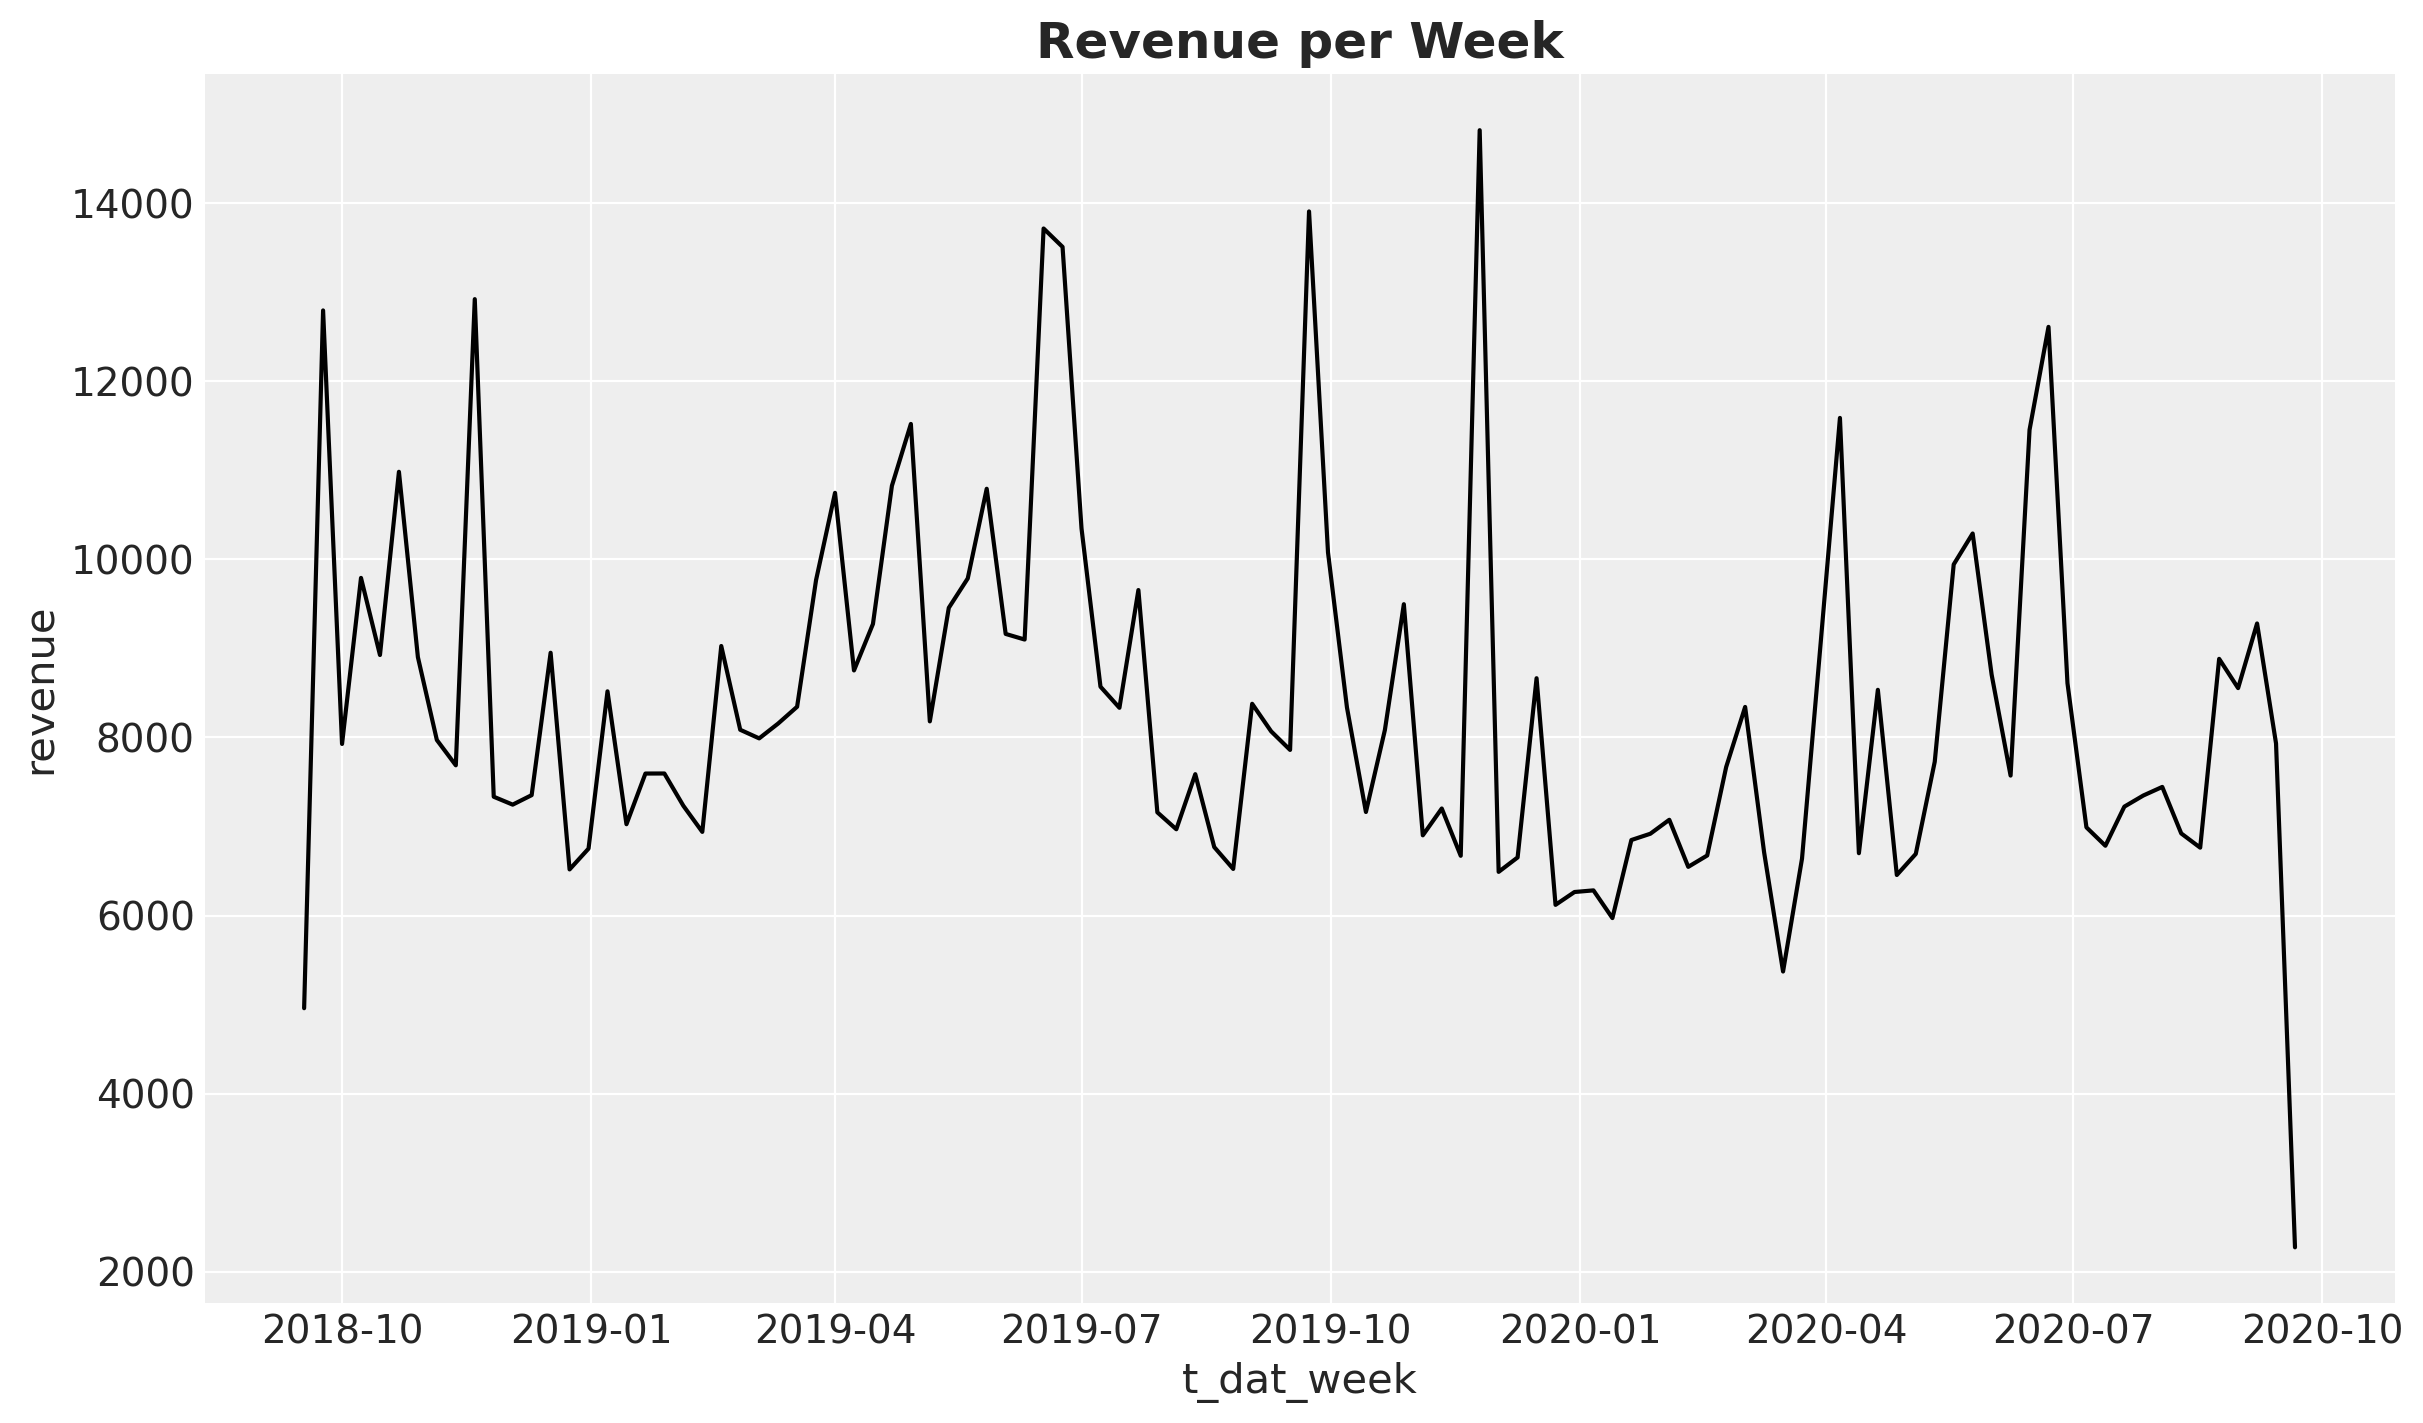

In [ ]:
fig, ax = plt.subplots()
(
    raw_df.with_columns(pl.col("t_dat").dt.truncate("1w").alias("t_dat_week"))
    .group_by("t_dat_week")
    .agg(pl.col("price").sum().alias("revenue"))
    .pipe(sns.lineplot, x="t_dat_week", y="revenue", color="black", ax=ax)
)
ax.set_title("Revenue per Week", fontsize=18, fontweight="bold")

## Data Preprocessing

We convert the Polars DataFrame to pandas for compatibility with PyMC and add derived columns.

In [ ]:
customers_df = (
    raw_df.rename({"t_dat": "date"})
    .with_columns(
        pl.col("date").cast(pl.Date()).dt.truncate("1mo").alias("period"),
    )
    .group_by(["period", "customer_id"])
    .agg(pl.col("price").sum().alias("revenue"))
    .with_columns(pl.col("period").min().over(["customer_id"]).alias("cohort"))
    .with_columns(
        pl.col("customer_id").unique().len().over(["cohort"]).alias("n_users")
    )
    .sort(["cohort", "customer_id", "period"])
)

customers_df.head()

shape: (5, 5)
┌────────────┬─────────────────────────────────┬──────────┬────────────┬─────────┐
│ period     ┆ customer_id                     ┆ revenue  ┆ cohort     ┆ n_users │
│ ---        ┆ ---                             ┆ ---      ┆ ---        ┆ ---     │
│ date       ┆ str                             ┆ f64      ┆ date       ┆ u32     │
╞════════════╪═════════════════════════════════╪══════════╪════════════╪═════════╡
│ 2018-09-01 ┆ 0000423b00ade91418cceaf3b26c6a… ┆ 0.29139  ┆ 2018-09-01 ┆ 140340  │
│ 2019-01-01 ┆ 0000423b00ade91418cceaf3b26c6a… ┆ 0.033881 ┆ 2018-09-01 ┆ 140340  │
│ 2019-04-01 ┆ 0000423b00ade91418cceaf3b26c6a… ┆ 0.169424 ┆ 2018-09-01 ┆ 140340  │
│ 2019-05-01 ┆ 0000423b00ade91418cceaf3b26c6a… ┆ 0.526915 ┆ 2018-09-01 ┆ 140340  │
│ 2019-06-01 ┆ 0000423b00ade91418cceaf3b26c6a… ┆ 0.176136 ┆ 2018-09-01 ┆ 140340  │
└────────────┴─────────────────────────────────┴──────────┴────────────┴─────────┘

In [ ]:
cohort_df = (
    customers_df.group_by(["cohort", "period"])
    .agg(
        pl.col("revenue").sum(),
        pl.col("n_users").mean().cast(pl.Int64()),
        pl.col("customer_id").n_unique().cast(pl.Int64()).alias("n_active_users"),
    )
    .with_columns(
        pl.col("n_active_users").truediv(pl.col("n_users")).alias("retention"),
        (pl.col("period") - pl.col("cohort")).dt.total_days().alias("cohort_age"),
        (pl.col("period").max() - pl.col("period")).dt.total_days().alias("age"),
        (pl.col("revenue").truediv(pl.col("n_users"))).alias("revenue_per_users"),
        (pl.col("revenue").truediv(pl.col("n_active_users"))).alias(
            "revenue_per_active_users"
        ),
    )
    .filter(pl.col("cohort") >= date(2018, 11, 1))
)

cohort_df.head()

shape: (5, 10)
┌────────────┬────────────┬─────────────┬─────────┬───┬────────────┬─────┬────────────┬────────────┐
│ cohort     ┆ period     ┆ revenue     ┆ n_users ┆ … ┆ cohort_age ┆ age ┆ revenue_pe ┆ revenue_pe │
│ ---        ┆ ---        ┆ ---         ┆ ---     ┆   ┆ ---        ┆ --- ┆ r_users    ┆ r_active_u │
│ date       ┆ date       ┆ f64         ┆ i64     ┆   ┆ i64        ┆ i64 ┆ ---        ┆ sers       │
│            ┆            ┆             ┆         ┆   ┆            ┆     ┆ f64        ┆ ---        │
│            ┆            ┆             ┆         ┆   ┆            ┆     ┆            ┆ f64        │
╞════════════╪════════════╪═════════════╪═════════╪═══╪════════════╪═════╪════════════╪════════════╡
│ 2018-11-01 ┆ 2018-12-01 ┆ 4221.784424 ┆ 138233  ┆ … ┆ 30         ┆ 640 ┆ 0.030541   ┆ 0.115818   │
│ 2019-11-01 ┆ 2020-01-01 ┆ 377.331085  ┆ 36990   ┆ … ┆ 61         ┆ 244 ┆ 0.010201   ┆ 0.098136   │
│ 2019-06-01 ┆ 2019-06-01 ┆ 6641.835949 ┆ 52127   ┆ … ┆ 0          ┆ 458 ┆ 0.127416   ┆ 0.127416   │
│ 2019-06-01 ┆ 2020-06-01 ┆ 987.166695  ┆ 52127   ┆ … ┆ 366        ┆ 92  ┆ 0.018938   ┆ 0.123011   │
│ 2018-12-01 ┆ 2019-06-01 ┆ 3049.667475 ┆ 89944   ┆ … ┆ 182        ┆ 458 ┆ 0.033906   ┆ 0.143063   │
└────────────┴────────────┴─────────────┴─────────┴───┴────────────┴─────┴────────────┴────────────┘

In [ ]:
assert cohort_df.null_count().to_series().sum() == 0

### Train-Test Split

We split the data into training and test sets based on a cutoff period.

In [ ]:
period_train_test_split = date(2020, 5, 1)

train_data_df = cohort_df.filter(pl.col("period") <= period_train_test_split).sort(
    ["cohort", "period"]
)

test_data_df = (
    cohort_df.filter(pl.col("period") > period_train_test_split)
    .filter(pl.col("cohort").is_in(train_data_df["cohort"].unique().to_list()))
    .sort(["cohort", "period"])
)

print(f"Train data shape: {train_data_df.shape}")
print(f"Test data shape: {test_data_df.shape}")

Train data shape: (190, 10)
Test data shape: (76, 10)


## EDA

Let's explore the data to understand the retention and revenue patterns.

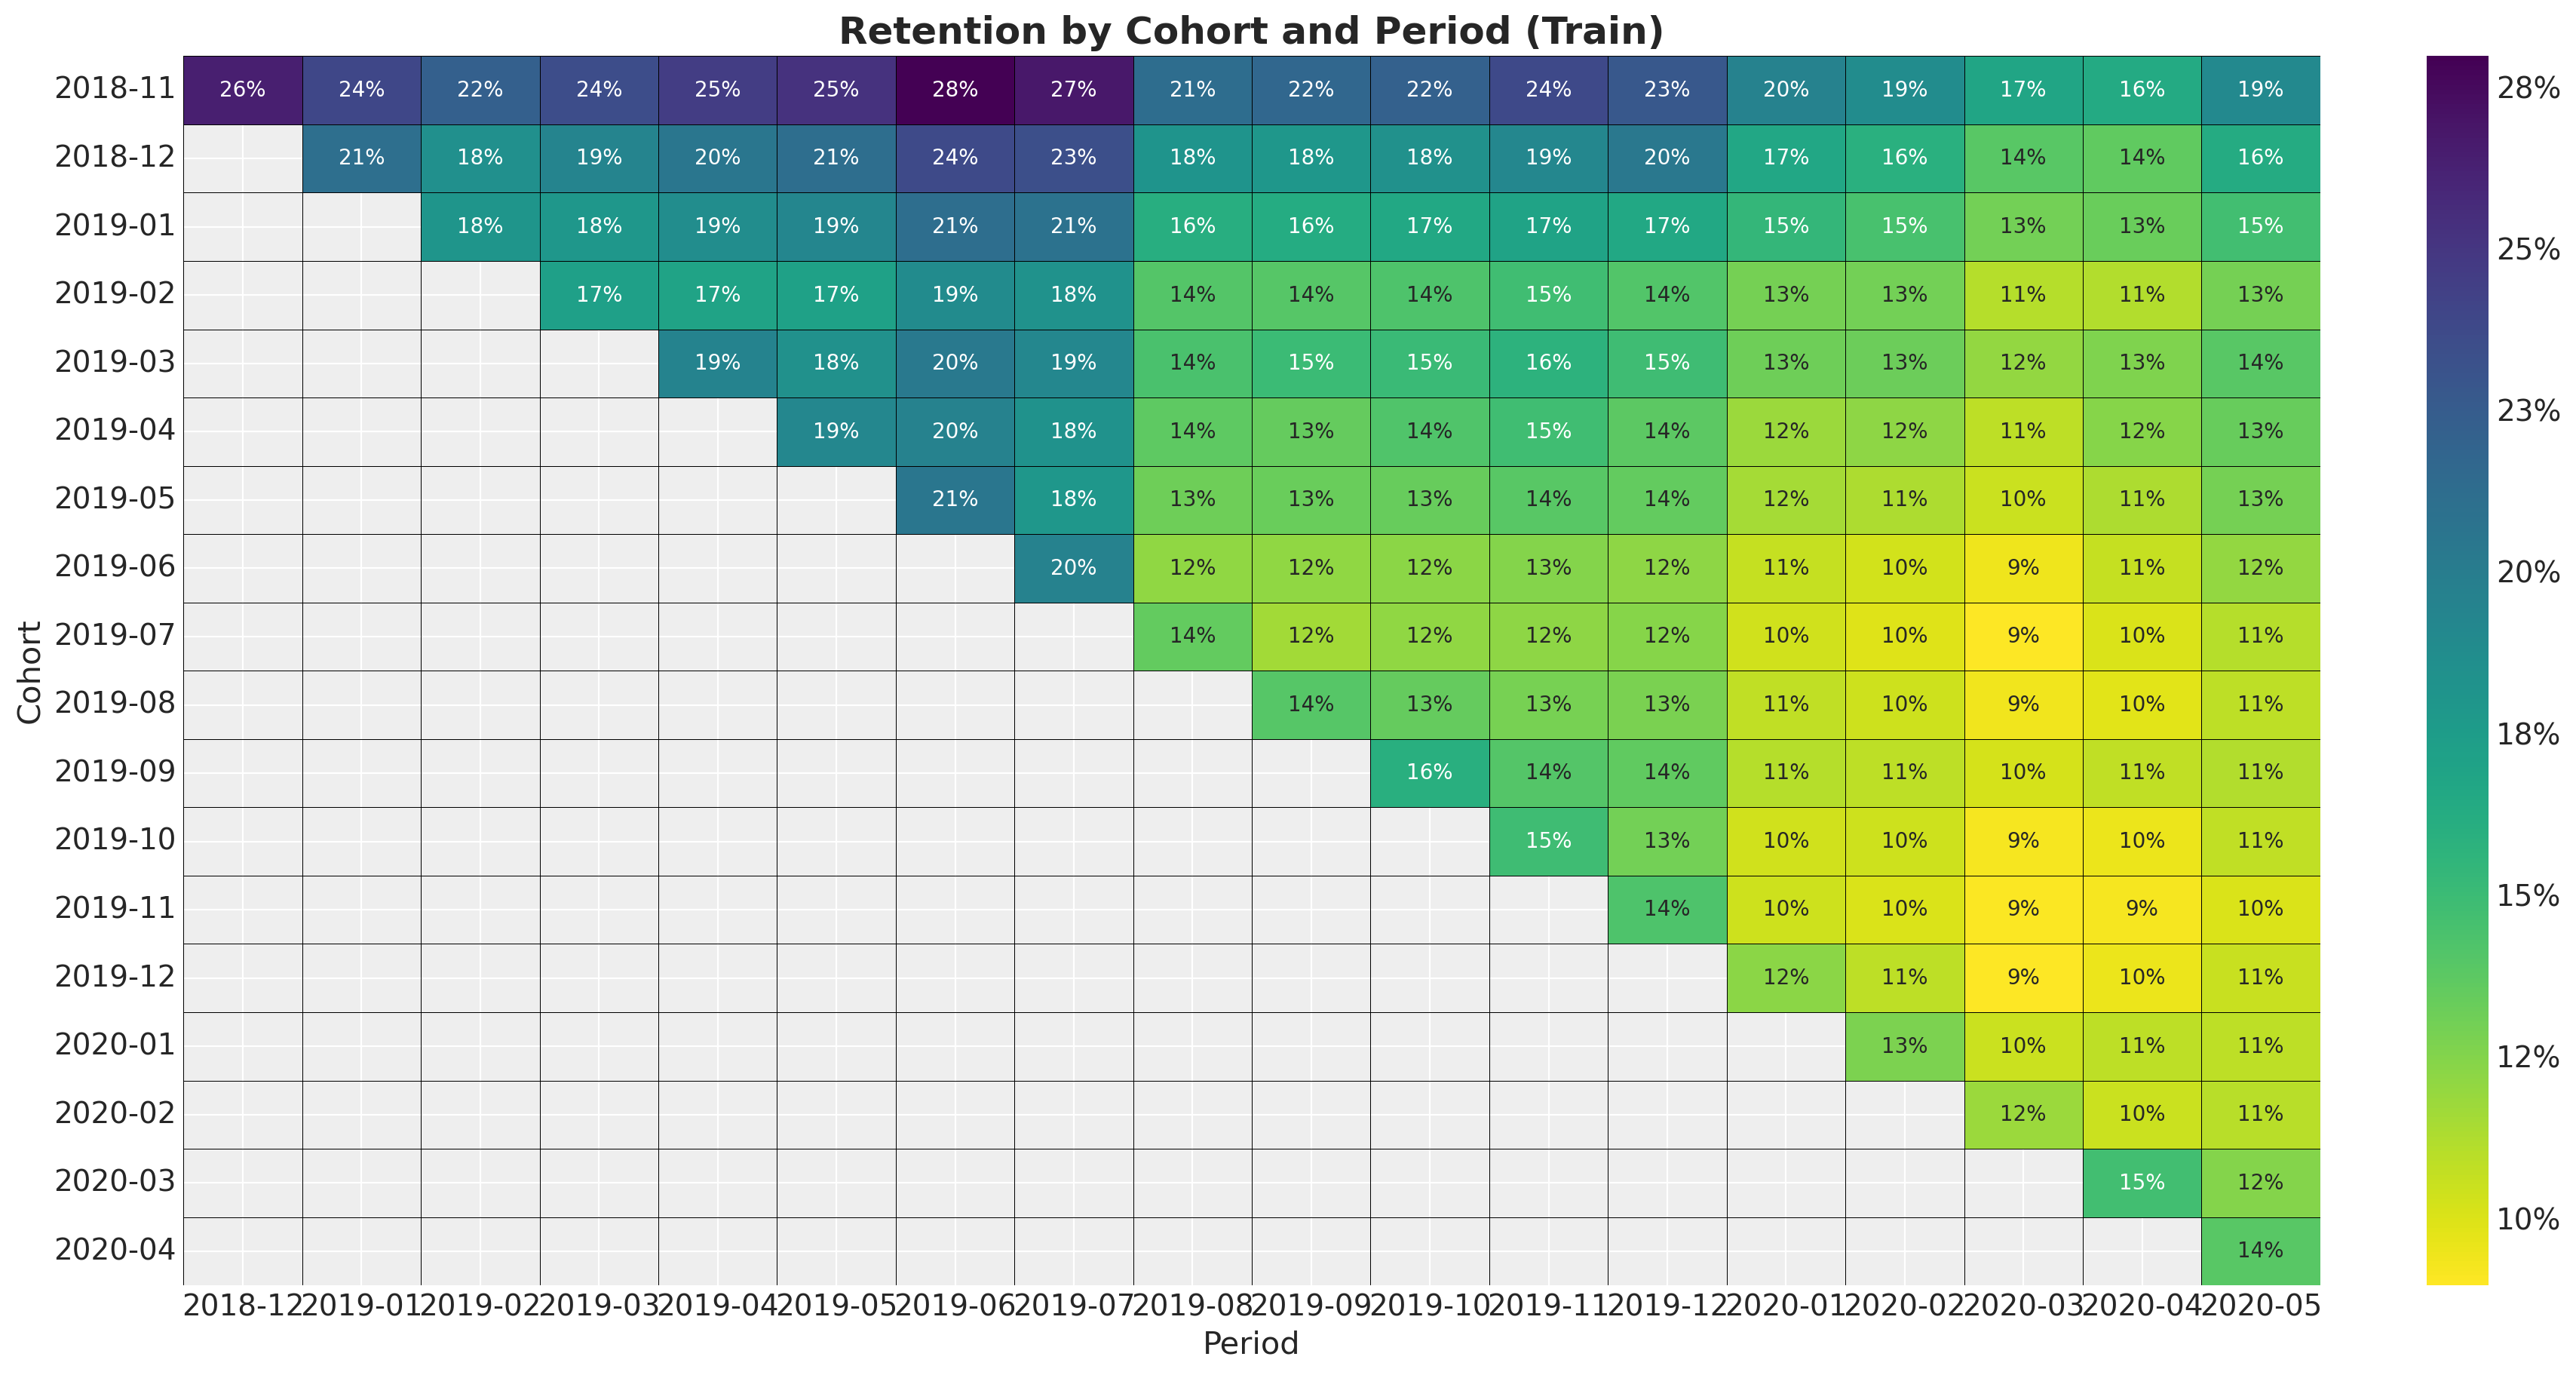

In [ ]:
fig, ax = plt.subplots(figsize=(17, 9))

fmt = lambda y, _: f"{y:0.0%}"  # noqa: E731

(
    train_data_df.filter(pl.col("cohort_age") != 0)  # noqa: PD010
    .select(
        [
            pl.col("cohort").dt.strftime("%Y-%m").alias("cohort"),
            pl.col("period").dt.strftime("%Y-%m").alias("period"),
            pl.col("retention"),
        ]
    )
    .pivot(index="cohort", on="period", values="retention")
    .to_pandas()
    .set_index("cohort")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0%",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.set(xlabel="Period", ylabel="Cohort")
ax.set_title("Retention by Cohort and Period (Train)", fontsize=18, fontweight="bold");

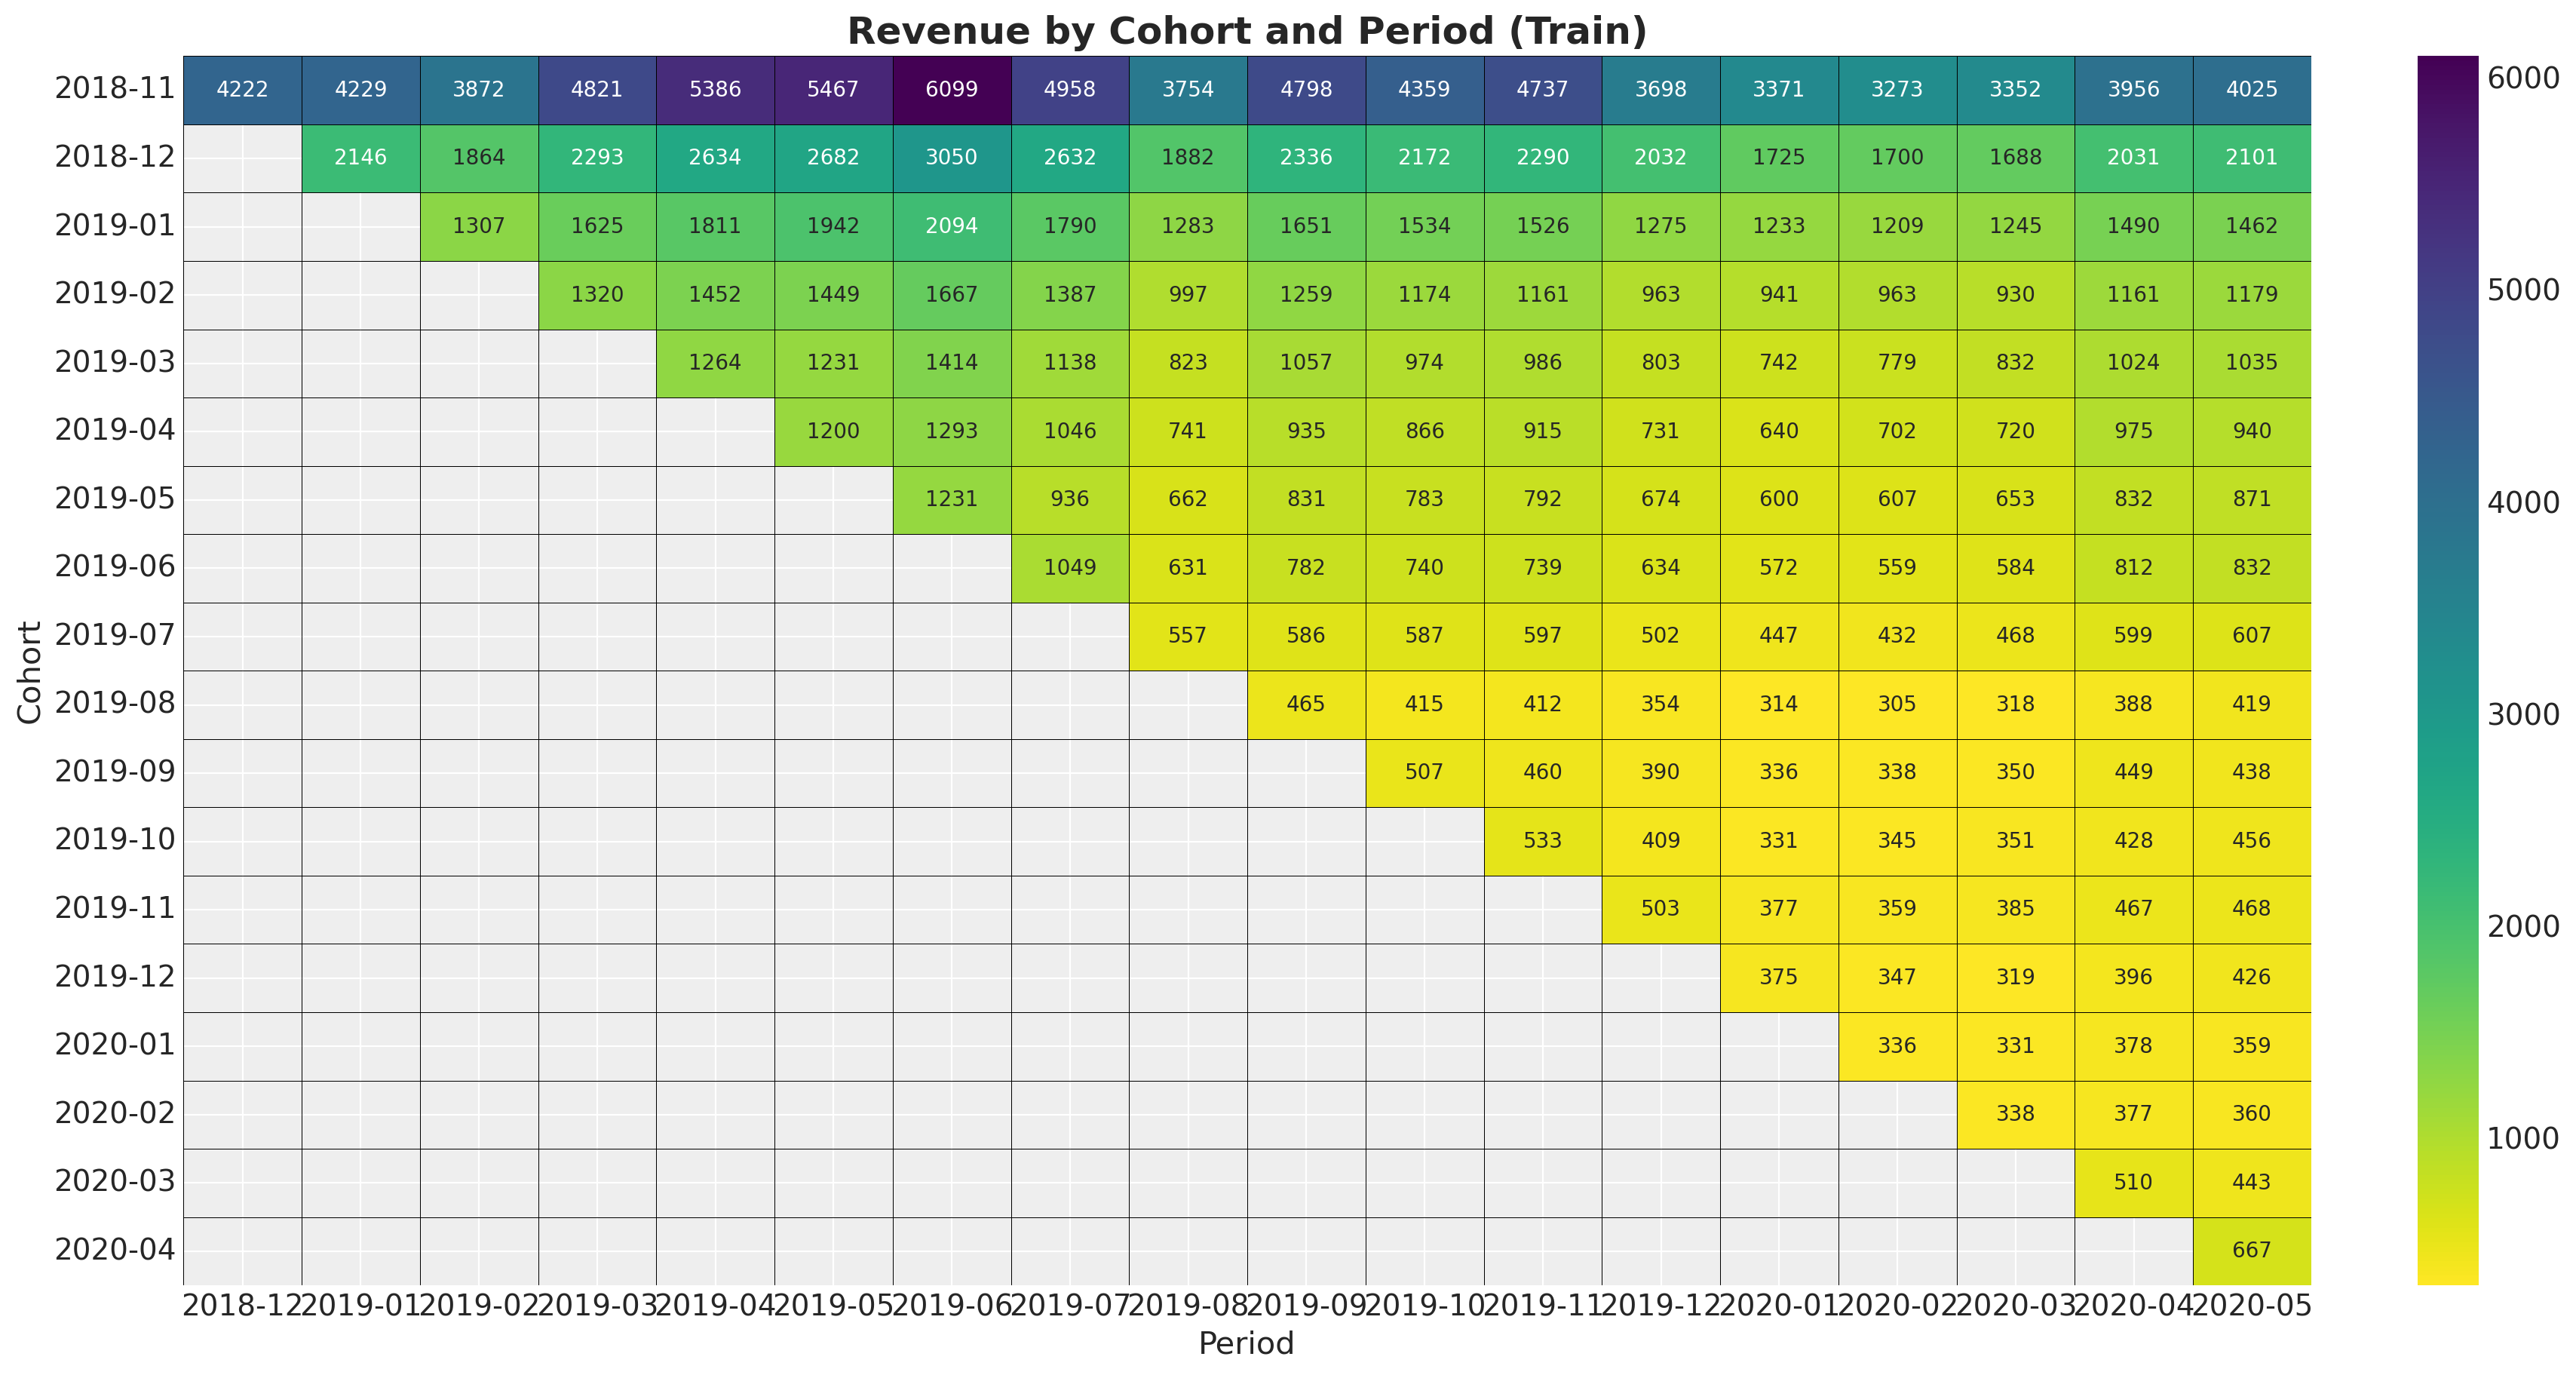

In [ ]:
fig, ax = plt.subplots(figsize=(17, 9))

fmt = lambda y, _: f"{y:0.0f}"  # noqa: E731

(
    train_data_df.filter(pl.col("cohort_age") != 0)  # noqa: PD010
    .select(
        [
            pl.col("cohort").dt.strftime("%Y-%m").alias("cohort"),
            pl.col("period").dt.strftime("%Y-%m").alias("period"),
            pl.col("revenue"),
        ]
    )
    .pivot(index="cohort", on="period", values="revenue")
    .to_pandas()
    .set_index("cohort")
    .pipe(
        (sns.heatmap, "data"),
        cmap="viridis_r",
        linewidths=0.2,
        linecolor="black",
        annot=True,
        fmt="0.0f",
        cbar_kws={"format": mtick.FuncFormatter(fmt)},
        ax=ax,
    )
)

ax.set(xlabel="Period", ylabel="Cohort")
ax.set_title("Revenue by Cohort and Period (Train)", fontsize=18, fontweight="bold");

### Retention Rate by Cohort Over Time

We plot the retention rate by cohort over time to illustrate the seasonality pattern.

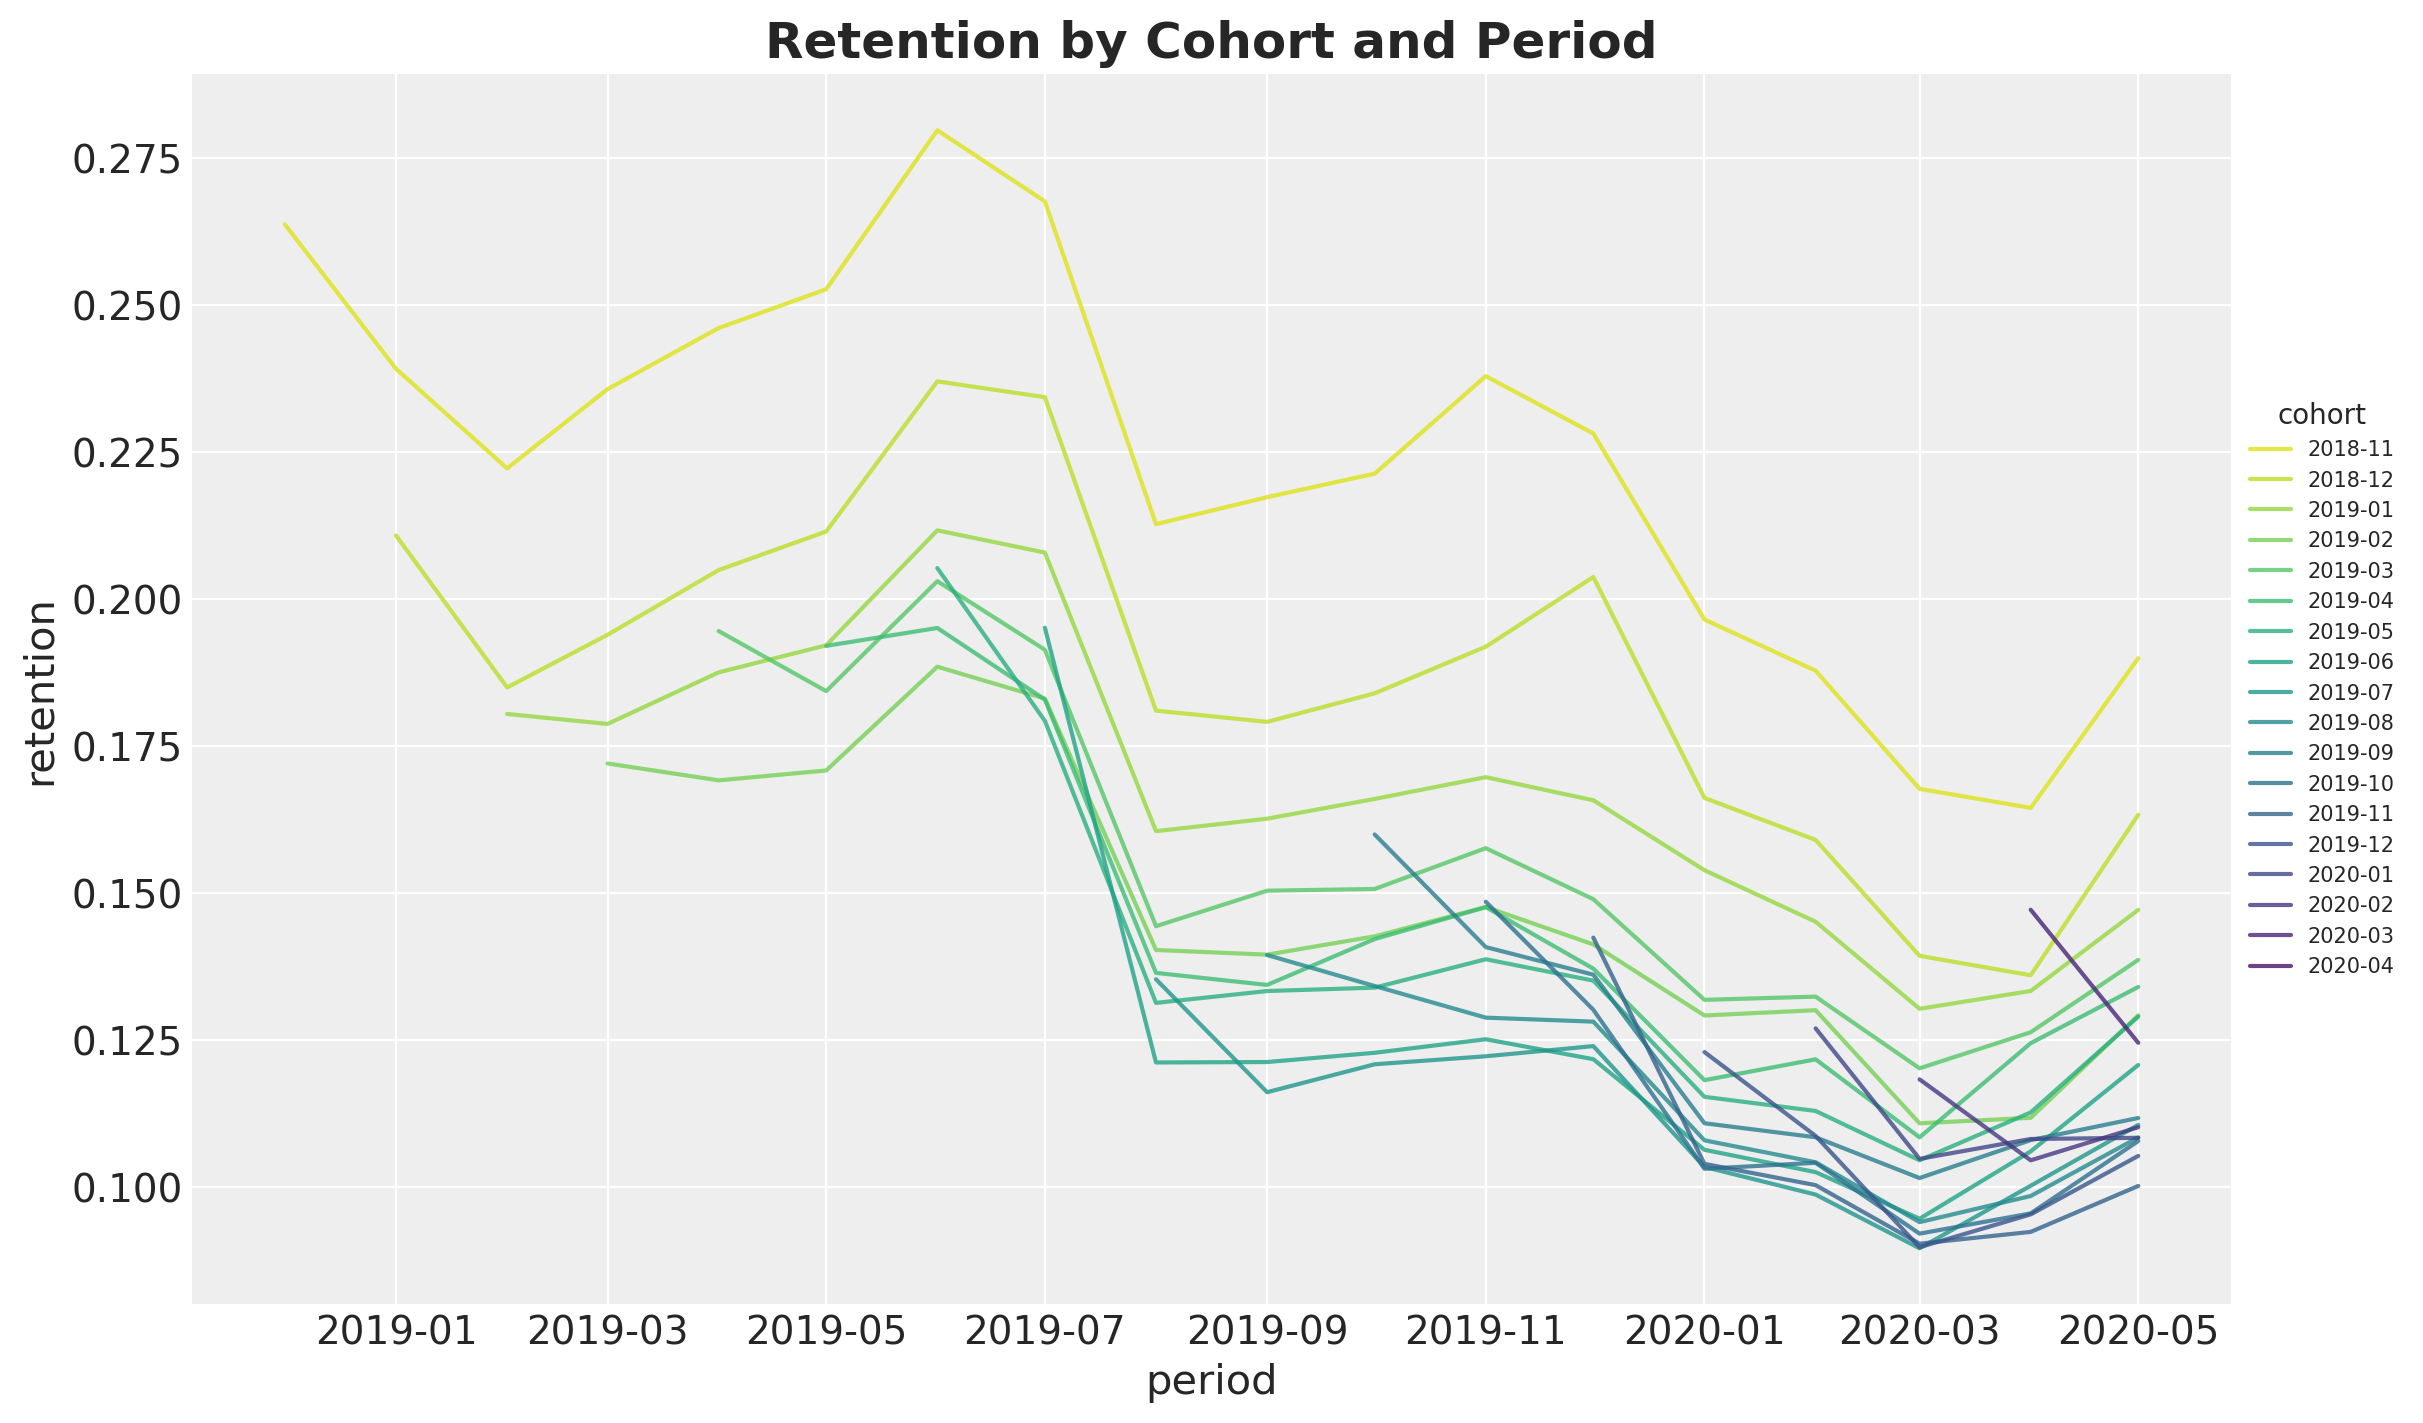

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.filter(pl.col("cohort_age").gt(pl.lit(0))).with_columns(
        pl.col("cohort").dt.strftime("%Y-%m").alias("cohort")
    ),
    ax=ax,
)
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set_title("Retention by Cohort and Period", fontsize=18, fontweight="bold");

## Model

We use a retention-revenue model with the following structure:

\begin{align*}
\text{Revenue} & \sim \text{Gamma}(N_{\text{active}}, \lambda) \\
\log(\lambda) = (& \text{intercept} \\
    & + \beta_{\text{cohort age}} \text{cohort age} \\
    & + \beta_{\text{age}} \text{age} \\
    & + \beta_{\text{cohort age} \times \text{age}} \text{cohort age} \times \text{age} ) \\
N_{\text{active}} & \sim \text{Binomial}(N_{\text{total}}, p) \\
\textrm{logit}(p) & = \text{BART}(\text{cohort age}, \text{age}, \text{month})
\end{align*}

### Data Transformations

We prepare the data for the PyMC model. This includes creating encoders, scalers, and
transforming features to the appropriate format.

In [ ]:
eps = np.finfo(float).eps

# Filter for cohort_age > 0
train_data_red_df = train_data_df.filter(pl.col("cohort_age") > 0)

# Add month features for seasonality (all in polars, in a single call)
train_data_red_df = train_data_red_df.with_columns(
    [
        pl.col("cohort").dt.month().alias("cohort_month"),
        pl.col("period").dt.month().alias("period_month"),
    ]
)

train_obs_idx = range(train_data_red_df.height)

# Extract arrays using polars .to_numpy()
train_n_users = train_data_red_df.get_column("n_users").to_numpy()
train_n_active_users = train_data_red_df.get_column("n_active_users").to_numpy()
train_retention = train_data_red_df.get_column("retention").to_numpy()
train_retention_logit = logit(train_retention + eps)
train_revenue = train_data_red_df.get_column("revenue").to_numpy() + eps
train_cohort = train_data_red_df.get_column("cohort").to_numpy()
train_period = train_data_red_df.get_column("period").to_numpy()

# Encoders for cohort and period
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()
train_cohort_month_encoder = LabelEncoder()
train_cohort_month_idx = train_cohort_month_encoder.fit_transform(
    train_data_red_df.get_column("cohort_month")
).flatten()
train_period_month_encoder = LabelEncoder()
train_period_month_idx = train_period_month_encoder.fit_transform(
    train_data_red_df.get_column("period_month")
).flatten()

# Features for BART model, extract as polars DataFrame
features: list[str] = ["age", "cohort_age", "cohort_month", "period_month"]
x_train = train_data_red_df.select(
    ["age", "cohort_age", "cohort_month", "period_month"]
).to_numpy()

# Age and cohort_age arrays and scaling using numpy
train_age = train_data_red_df.get_column("age").to_numpy()
train_age_scaler = MaxAbsScaler()
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()

train_cohort_age = train_data_red_df.get_column("cohort_age").to_numpy()
train_cohort_age_scaler = MaxAbsScaler()
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(
    train_cohort_age.reshape(-1, 1)
).flatten()

In [ ]:
print(f"Number of observations: {len(train_obs_idx)}")
print(f"Number of unique cohorts: {len(train_cohort_encoder.classes_)}")
print(f"Number of unique periods: {len(train_period_encoder.classes_)}")

Number of observations: 171
Number of unique cohorts: 18
Number of unique periods: 18


### Model Specification

We specify the PyMC model with:
- A BART component for the retention rate (on the logit scale)
- A linear model for the revenue rate using a Gamma distribution
- The retention and revenue components are coupled through the estimated number of active users

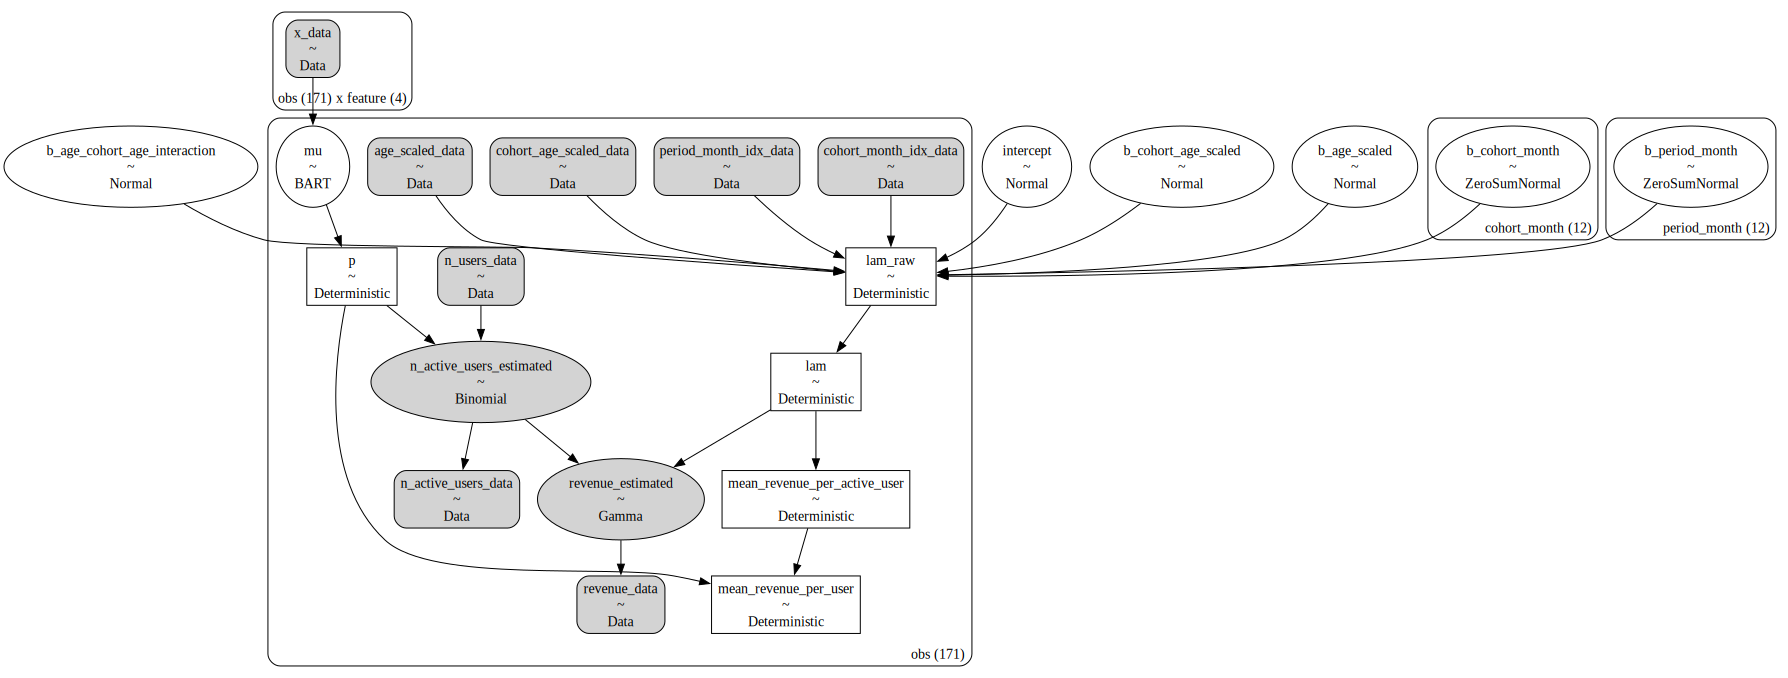

In [ ]:
coords = {
    "feature": features,
    "obs": train_obs_idx,
    "cohort_month": train_cohort_month_encoder.classes_,
    "period_month": train_period_month_encoder.classes_,
}

with pm.Model(coords=coords) as model:
    # --- Data ---
    age_scaled_data = pm.Data(
        name="age_scaled_data", value=train_age_scaled, dims="obs"
    )
    cohort_age_scaled_data = pm.Data(
        name="cohort_age_scaled_data", value=train_cohort_age_scaled, dims="obs"
    )
    cohort_month_idx_data = pm.Data(
        name="cohort_month_idx_data", value=train_cohort_month_idx, dims="obs"
    )
    period_month_idx_data = pm.Data(
        name="period_month_idx_data", value=train_period_month_idx, dims="obs"
    )
    x_data = pm.Data(name="x_data", value=x_train, dims=("obs", "feature"))
    n_users_data = pm.Data(name="n_users_data", value=train_n_users, dims="obs")
    n_active_users_data = pm.Data(
        name="n_active_users_data", value=train_n_active_users, dims="obs"
    )
    revenue_data = pm.Data(name="revenue_data", value=train_revenue, dims="obs")

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=2)
    b_age_scaled = pm.Normal(name="b_age_scaled", mu=0, sigma=2)
    b_cohort_age_scaled = pm.Normal(name="b_cohort_age_scaled", mu=0, sigma=2)
    b_age_cohort_age_interaction = pm.Normal(
        name="b_age_cohort_age_interaction", mu=0, sigma=1
    )
    b_cohort_month = pm.ZeroSumNormal(
        name="b_cohort_month", sigma=3, dims="cohort_month"
    )
    b_period_month = pm.ZeroSumNormal(
        name="b_period_month", sigma=3, dims="period_month"
    )

    # --- Parametrization ---
    # The BART component models the image of the retention rate under the
    # logit transform so that the range is not constrained to [0, 1].
    mu = pmb.BART(
        name="mu",
        X=x_data,
        Y=train_retention_logit,
        m=200,
        response="mixed",
        split_rules=[
            ContinuousSplitRule(),
            ContinuousSplitRule(),
            SubsetSplitRule(),
            SubsetSplitRule(),
        ],
        dims="obs",
    )
    # We use the inverse logit transform to get the retention rate back into [0, 1].
    p = pm.Deterministic(name="p", var=pm.math.invlogit(mu), dims="obs")
    # We add a small epsilon to avoid numerical issues.
    p = pt.switch(pt.eq(p, 0), eps, p)
    p = pt.switch(pt.eq(p, 1), 1 - eps, p)

    # For the revenue component we use a Gamma distribution where we combine the number
    # of estimated active users with the average revenue per user.
    lam_raw = pm.Deterministic(
        name="lam_raw",
        var=intercept
        + b_age_scaled * age_scaled_data
        + b_cohort_age_scaled * cohort_age_scaled_data
        + b_age_cohort_age_interaction * age_scaled_data * cohort_age_scaled_data
        + b_cohort_month[cohort_month_idx_data]
        + b_period_month[period_month_idx_data],
        dims="obs",
    )

    lam = pm.Deterministic(name="lam", var=pt.softplus(lam_raw), dims="obs")

    # --- Likelihood ---
    n_active_users_estimated = pm.Binomial(
        name="n_active_users_estimated",
        n=n_users_data,
        p=p,
        observed=n_active_users_data,
        dims="obs",
    )

    revenue_estimated = pm.Gamma(
        name="revenue_estimated",
        alpha=n_active_users_estimated + eps,
        beta=lam,
        observed=revenue_data,
        dims="obs",
    )

    mean_revenue_per_active_user = pm.Deterministic(
        name="mean_revenue_per_active_user", var=(1 / lam), dims="obs"
    )
    pm.Deterministic(
        name="mean_revenue_per_user", var=p * mean_revenue_per_active_user, dims="obs"
    )

pm.model_to_graphviz(model=model)

### Model Fitting

Now we fit the model using MCMC sampling.

In [ ]:
with model:
    idata = pm.sample(tune=1_000, draws=300, chains=14, cores=14, random_seed=rng)
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=rng))

Multiprocess sampling (14 chains in 14 jobs)
CompoundStep
>NUTS: [intercept, b_age_scaled, b_cohort_age_scaled, b_age_cohort_age_interaction, b_cohort_month, b_period_month]
>PGBART: [mu]


Output()

Sampling 14 chains for 1_000 tune and 300 draw iterations (14_000 + 4_200 draws total) took 82 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [n_active_users_estimated, revenue_estimated]


Output()

## Model Diagnostics

We examine the posterior predictive checks and trace plots to ensure the model has converged properly.

### Posterior Predictive Check

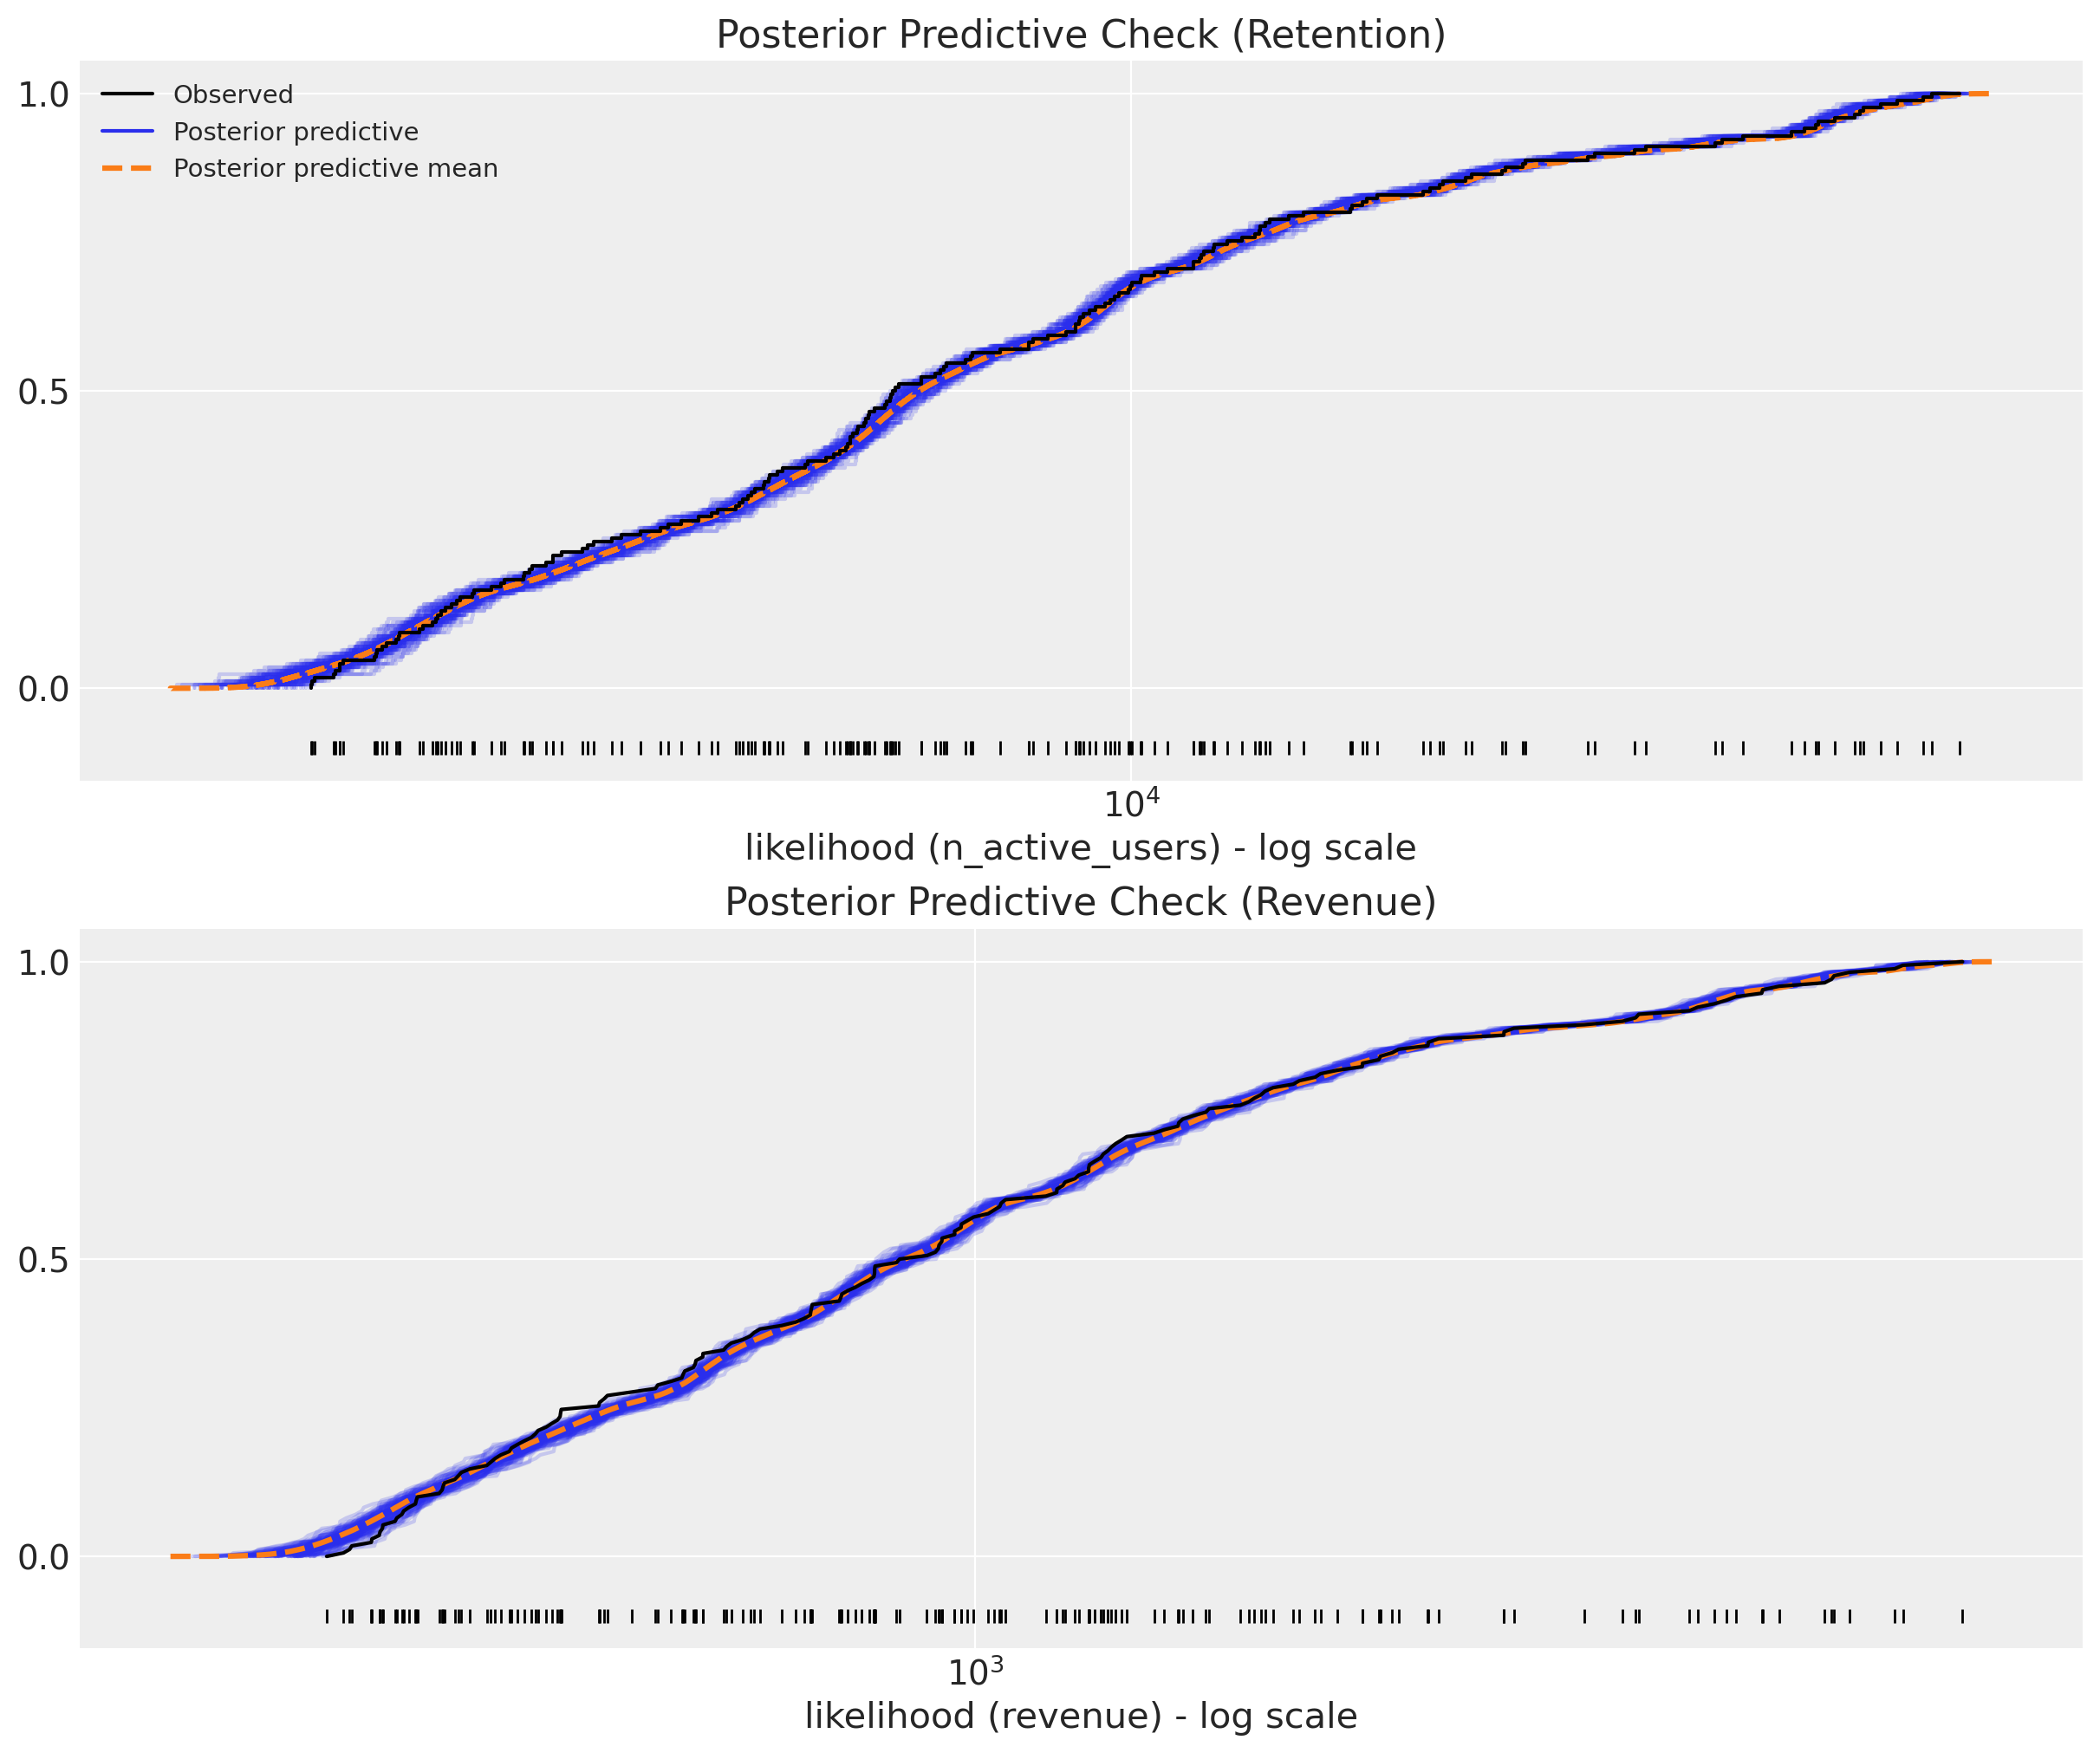

In [ ]:
ax = az.plot_ppc(
    data=idata,
    kind="cumulative",
    num_pp_samples=100,
    observed_rug=True,
    grid=(2, 1),
    figsize=(12, 10),
    random_seed=seed,
)
ax[0].set(
    title="Posterior Predictive Check (Retention)",
    xscale="log",
    xlabel="likelihood (n_active_users) - log scale",
)
ax[1].set(
    title="Posterior Predictive Check (Revenue)",
    xscale="log",
    xlabel="likelihood (revenue) - log scale",
);

### Check for Divergences

In [ ]:
n_divergences = idata.sample_stats["diverging"].sum().item()
print(f"Number of divergences: {n_divergences}")
assert n_divergences == 0, f"Model has {n_divergences} divergences!"

Number of divergences: 0


### Trace Plots for Revenue Parameters

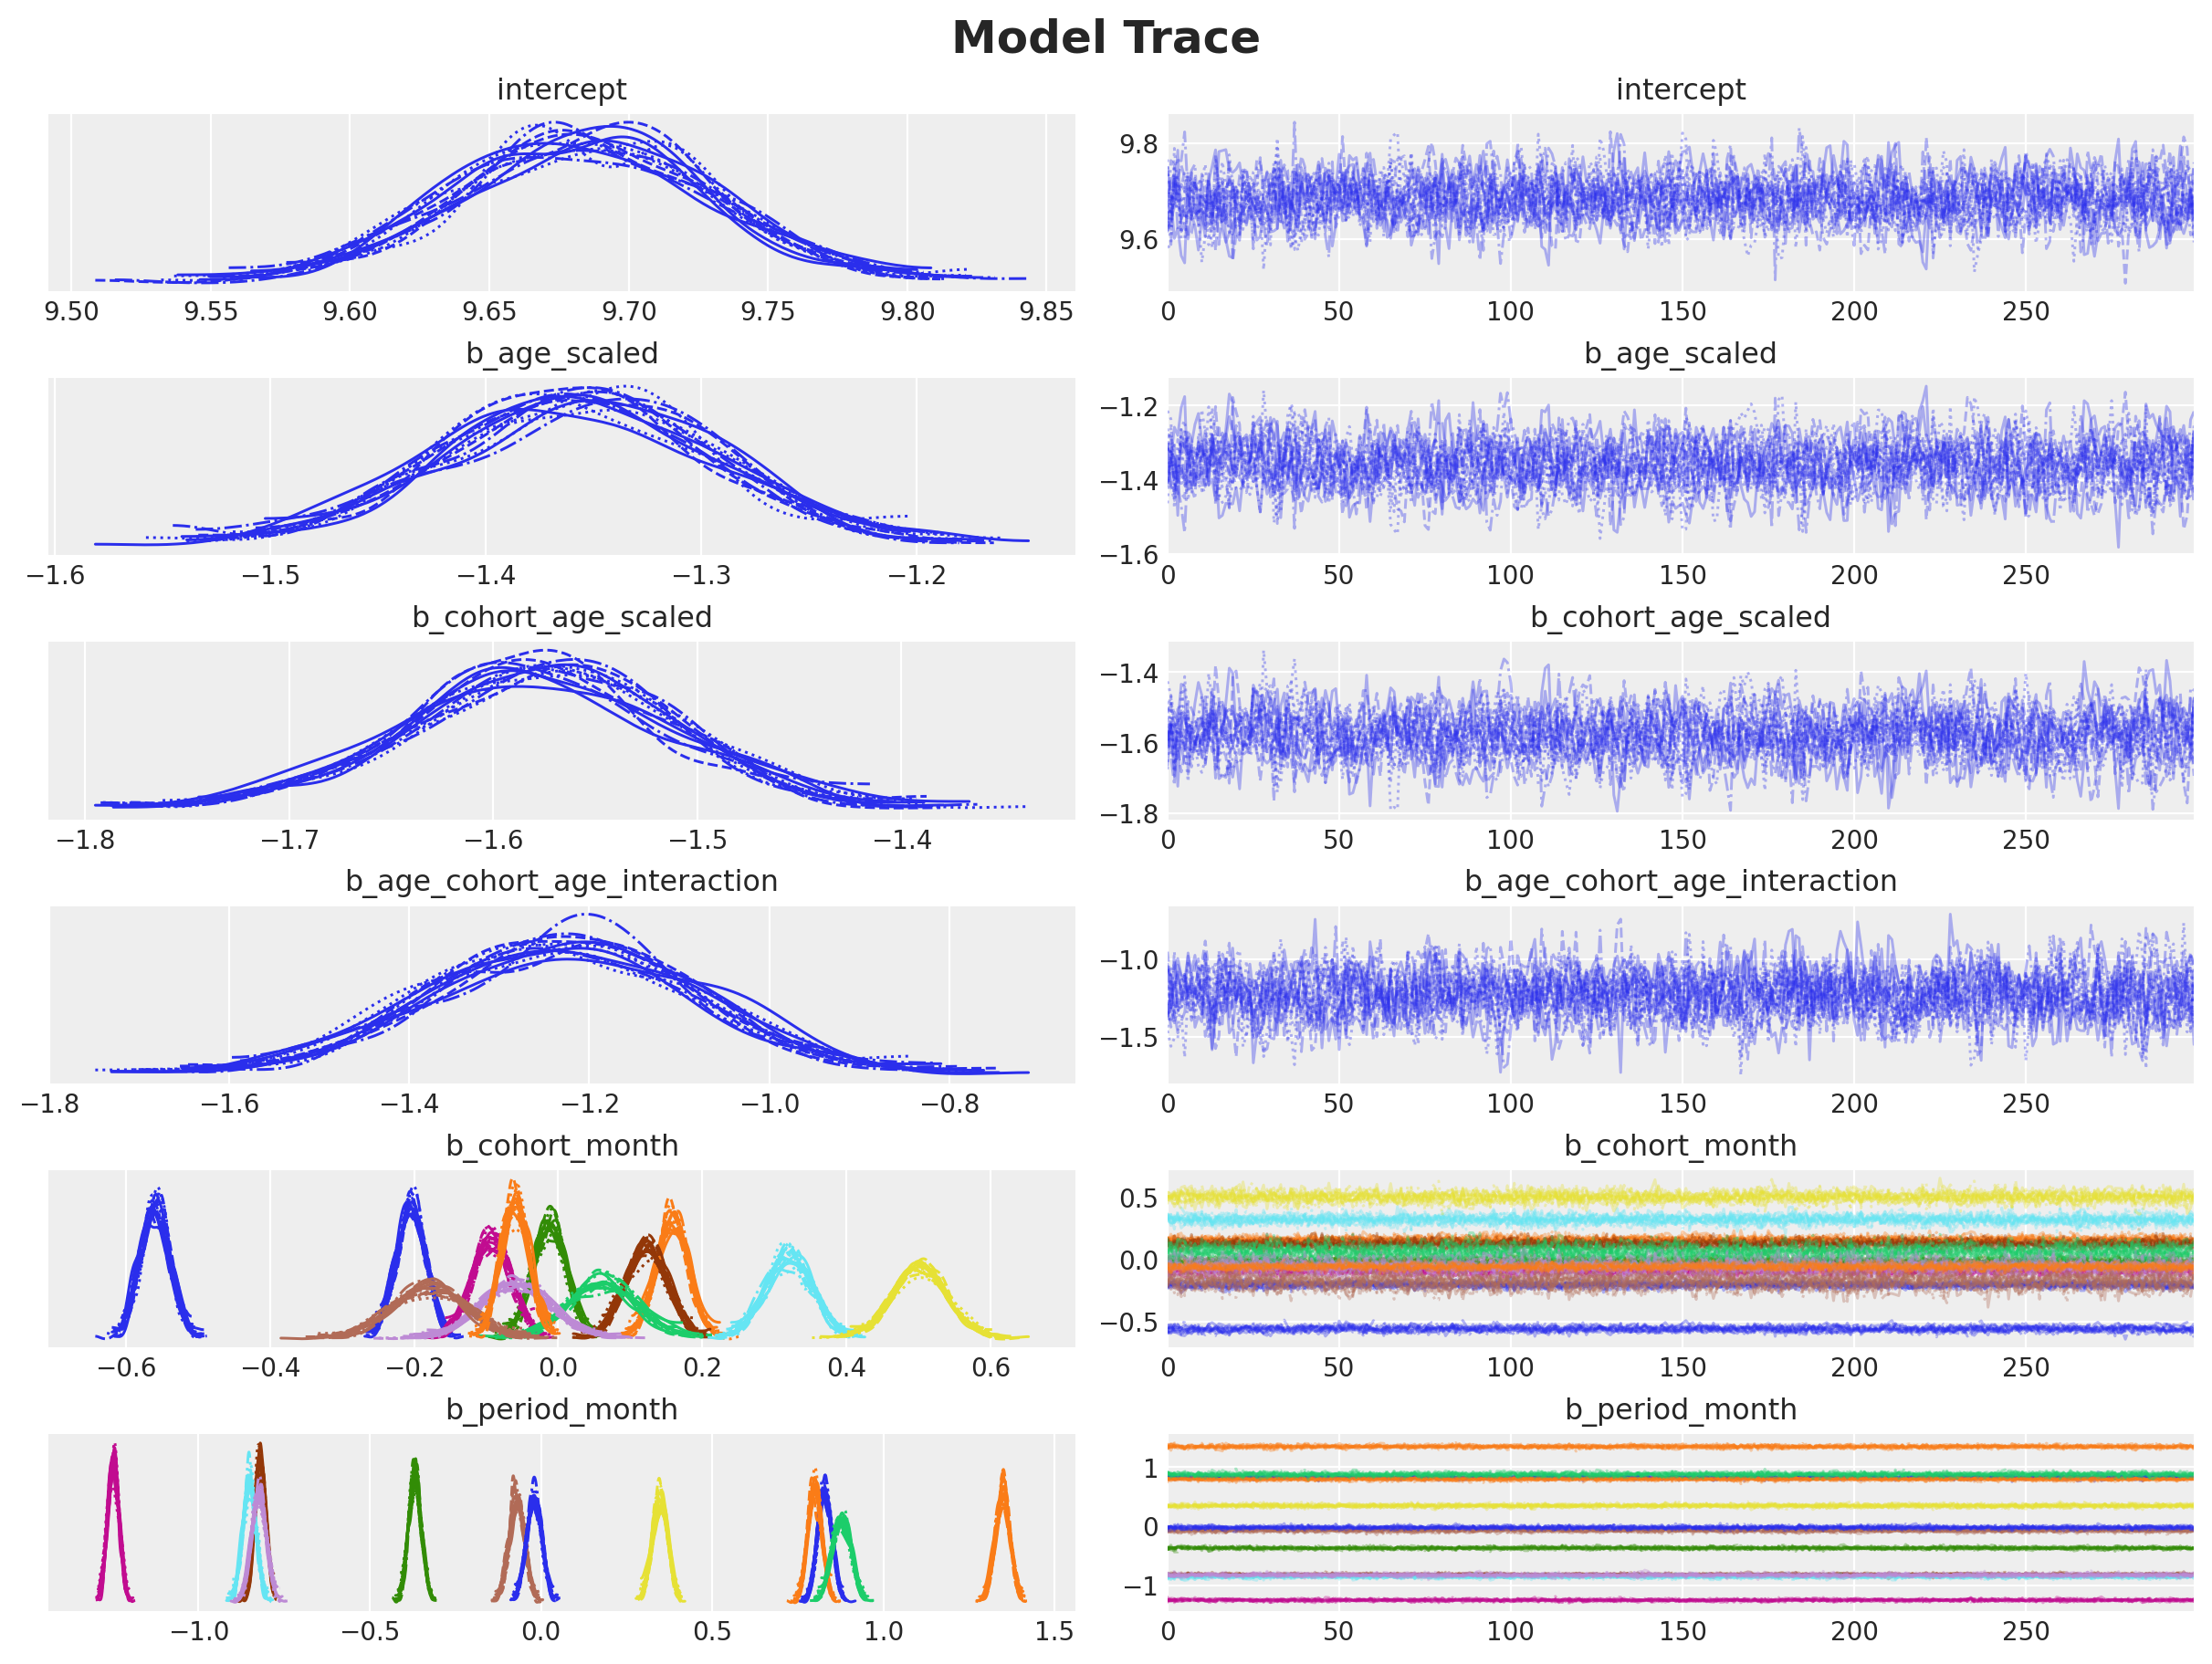

In [ ]:
_ = az.plot_trace(
    data=idata,
    var_names=[
        "intercept",
        "b_age_scaled",
        "b_cohort_age_scaled",
        "b_age_cohort_age_interaction",
        "b_cohort_month",
        "b_period_month",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold");

## In-Sample Predictions

We examine how well the model fits the training data by comparing the posterior means
with the observed values.

### Retention

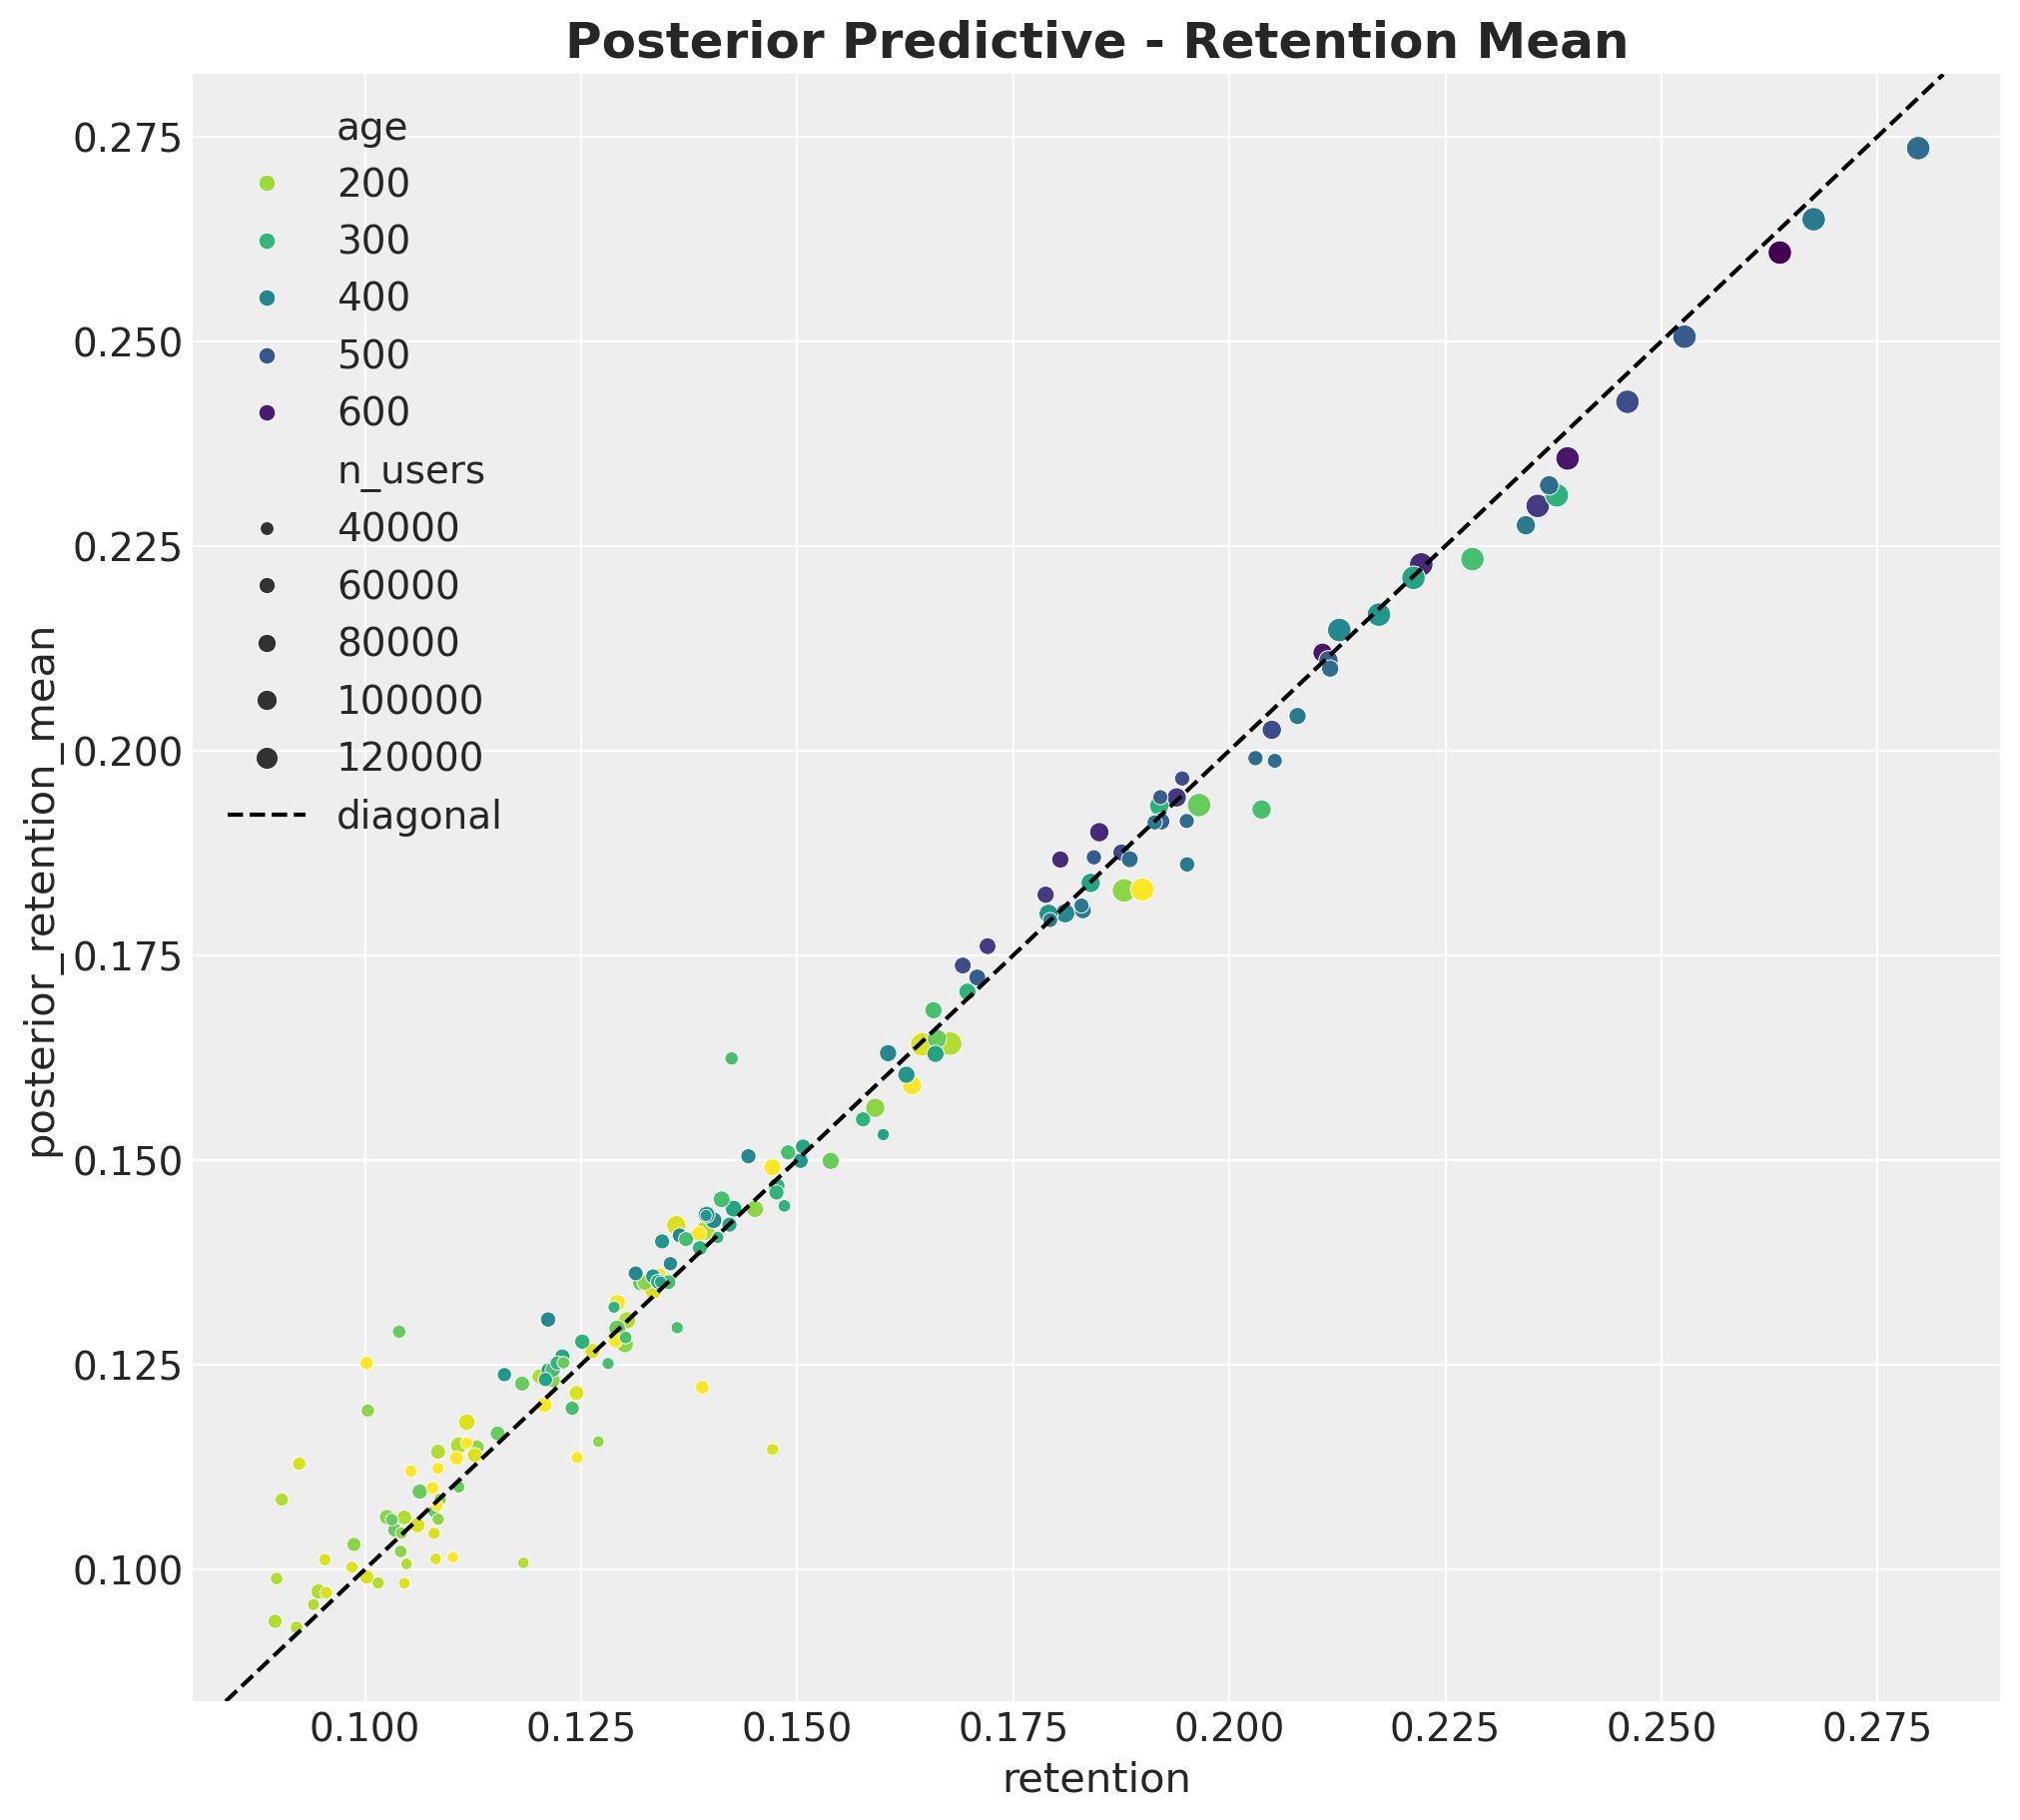

In [ ]:
train_posterior_retention = (
    idata["posterior_predictive"]["n_active_users_estimated"]
    / train_n_users[np.newaxis, None]
)
train_posterior_retention_mean = az.extract(
    data=train_posterior_retention, var_names=["n_active_users_estimated"]
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="retention",
    y="posterior_retention_mean",
    data=train_data_red_df.to_pandas().assign(
        posterior_retention_mean=train_posterior_retention_mean
    ),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(0.1, 0.1), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set_title("Posterior Predictive - Retention Mean", fontsize=18, fontweight="bold");

### Revenue

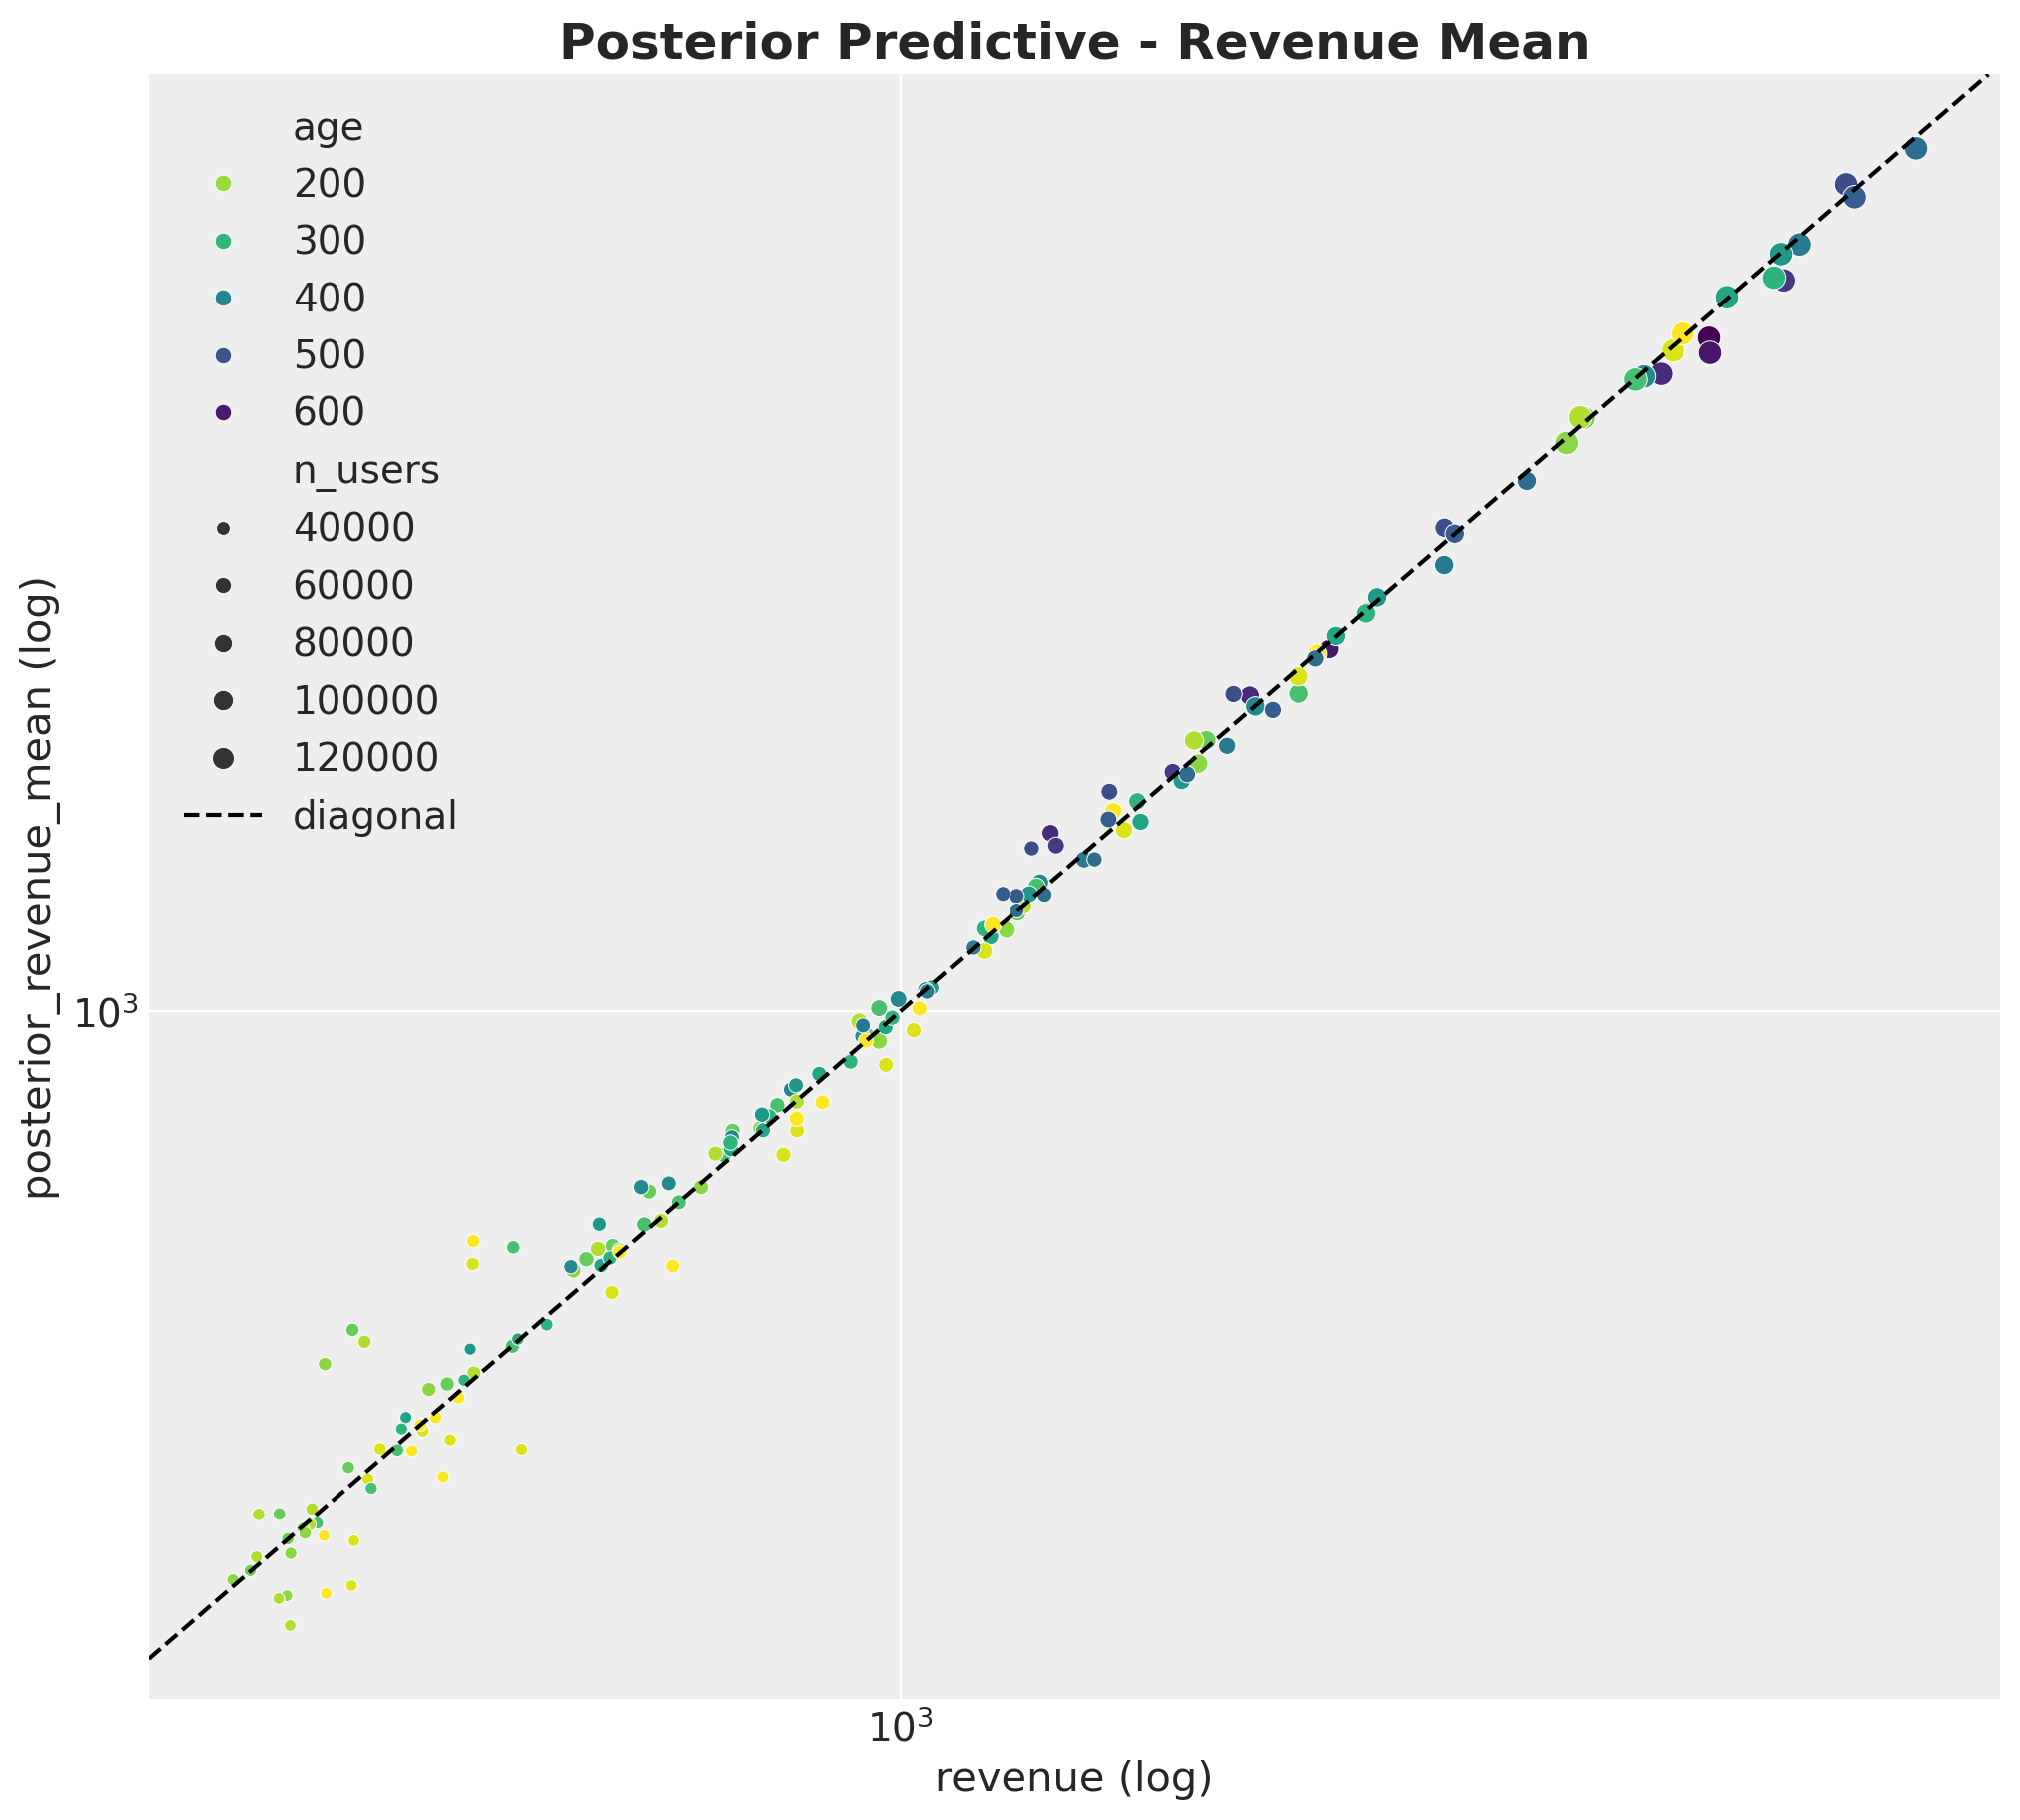

In [ ]:
train_posterior_revenue_mean = az.extract(
    data=idata["posterior_predictive"],
    group="posterior_predictive",
    var_names=["revenue_estimated"],
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="revenue",
    y="posterior_revenue_mean",
    data=train_data_red_df.to_pandas().assign(
        posterior_revenue_mean=train_posterior_revenue_mean
    ),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(1e3, 1e3), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    xscale="log",
    yscale="log",
    xlabel="revenue (log)",
    ylabel="posterior_revenue_mean (log)",
)
ax.set_title("Posterior Predictive - Revenue Mean", fontsize=18, fontweight="bold");

### In-Sample HDI Plots by Cohort

We plot the HDI (Highest Density Interval) for a subset of cohorts to visualize
the uncertainty in the predictions.

#### Retention HDI

In [ ]:
train_retention_hdi = az.hdi(ary=train_posterior_retention)["n_active_users_estimated"]


def plot_train_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_retention_hdi[mask, :][:, 0],
        y2=train_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C0",
        label="94% HDI (train)",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_retention[mask],
        color="C0",
        marker="o",
        label="observed retention (train)",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Retention HDI - Cohort {cohort_name}")
    return ax

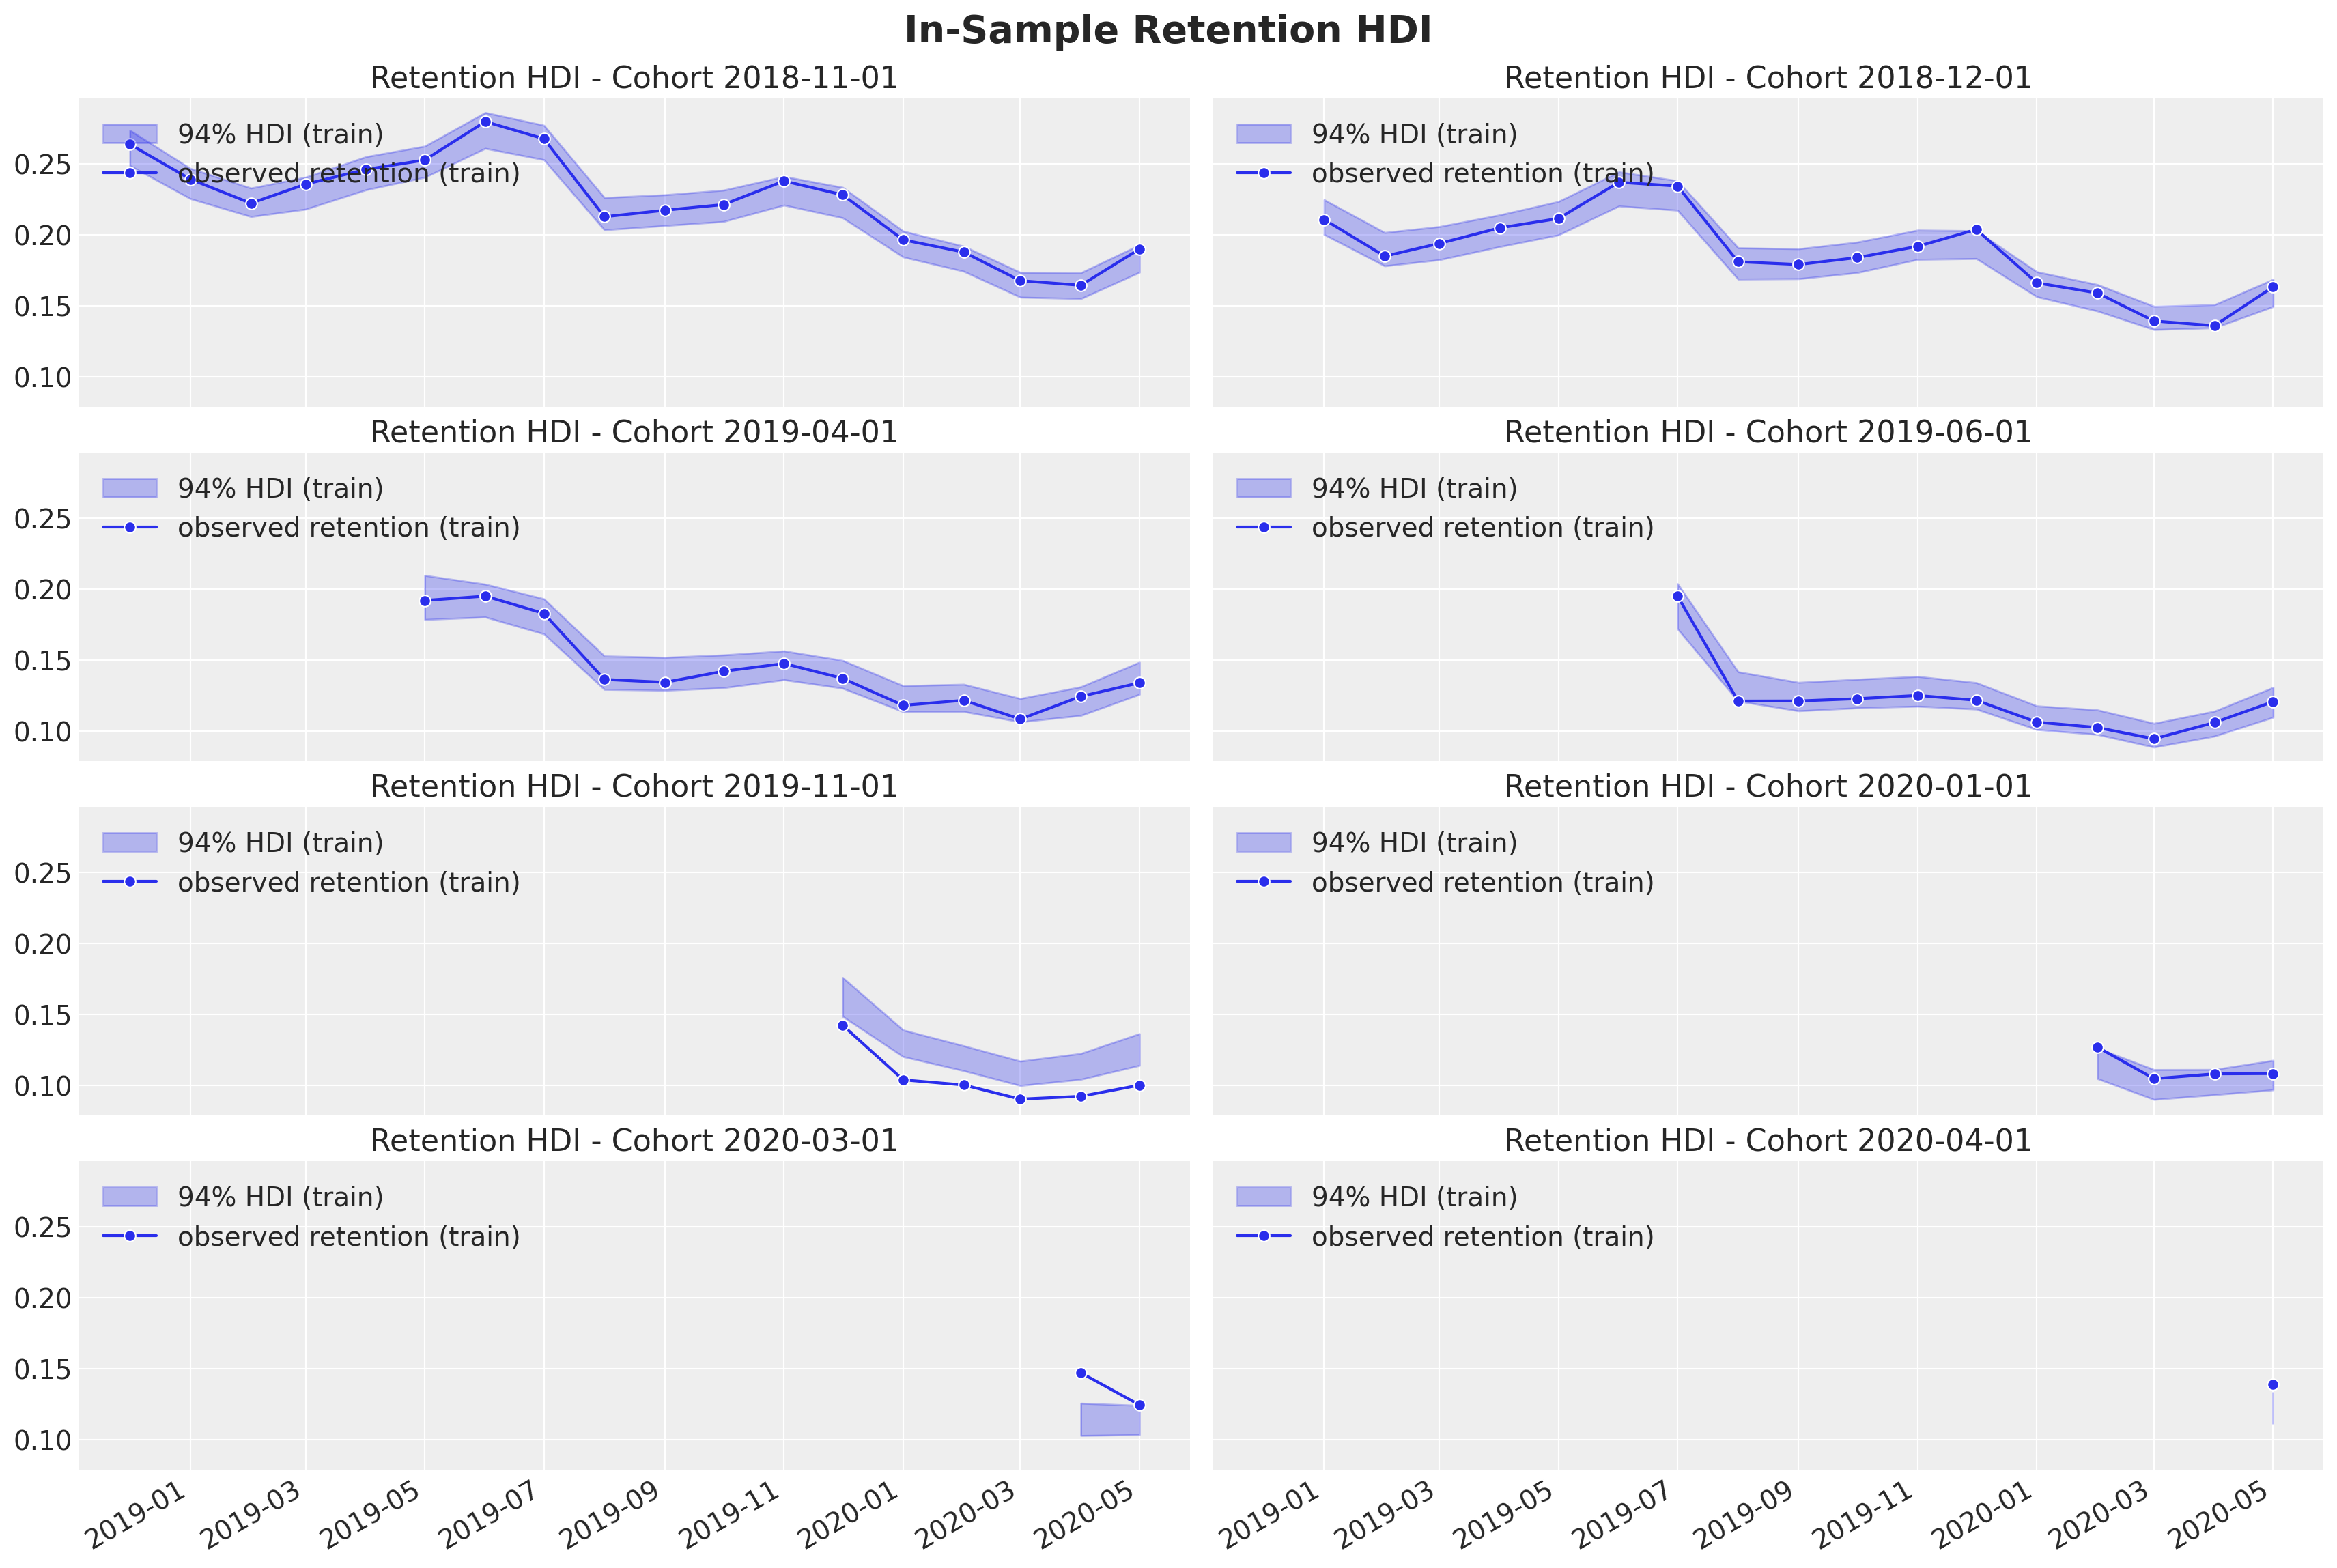

In [ ]:
# Select cohorts to plot (adjust indices based on available cohorts)
n_cohorts = len(train_cohort_encoder.classes_)
cohort_index_to_plot = [0, 1, 5, 7, 12, 14, 16, 17]
cohort_index_to_plot = [i for i in cohort_index_to_plot if i < n_cohorts]

fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(17, 11),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)

fig.suptitle("In-Sample Retention HDI", y=1.03, fontsize=20, fontweight="bold")
fig.autofmt_xdate()

#### Revenue HDI

In [ ]:
train_revenue_hdi = az.hdi(ary=idata["posterior_predictive"])["revenue_estimated"]


def plot_train_revenue_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index

    ax.fill_between(
        x=train_period[train_period_idx[mask]],
        y1=train_revenue_hdi[mask, :][:, 0],
        y2=train_revenue_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C0",
        label="94% HDI (train)",
    )
    sns.lineplot(
        x=train_period[train_period_idx[mask]],
        y=train_revenue[mask],
        color="C0",
        marker="o",
        label="observed revenue (train)",
        ax=ax,
    )
    cohort_name = (
        pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Revenue HDI - Cohort {cohort_name}")
    return ax

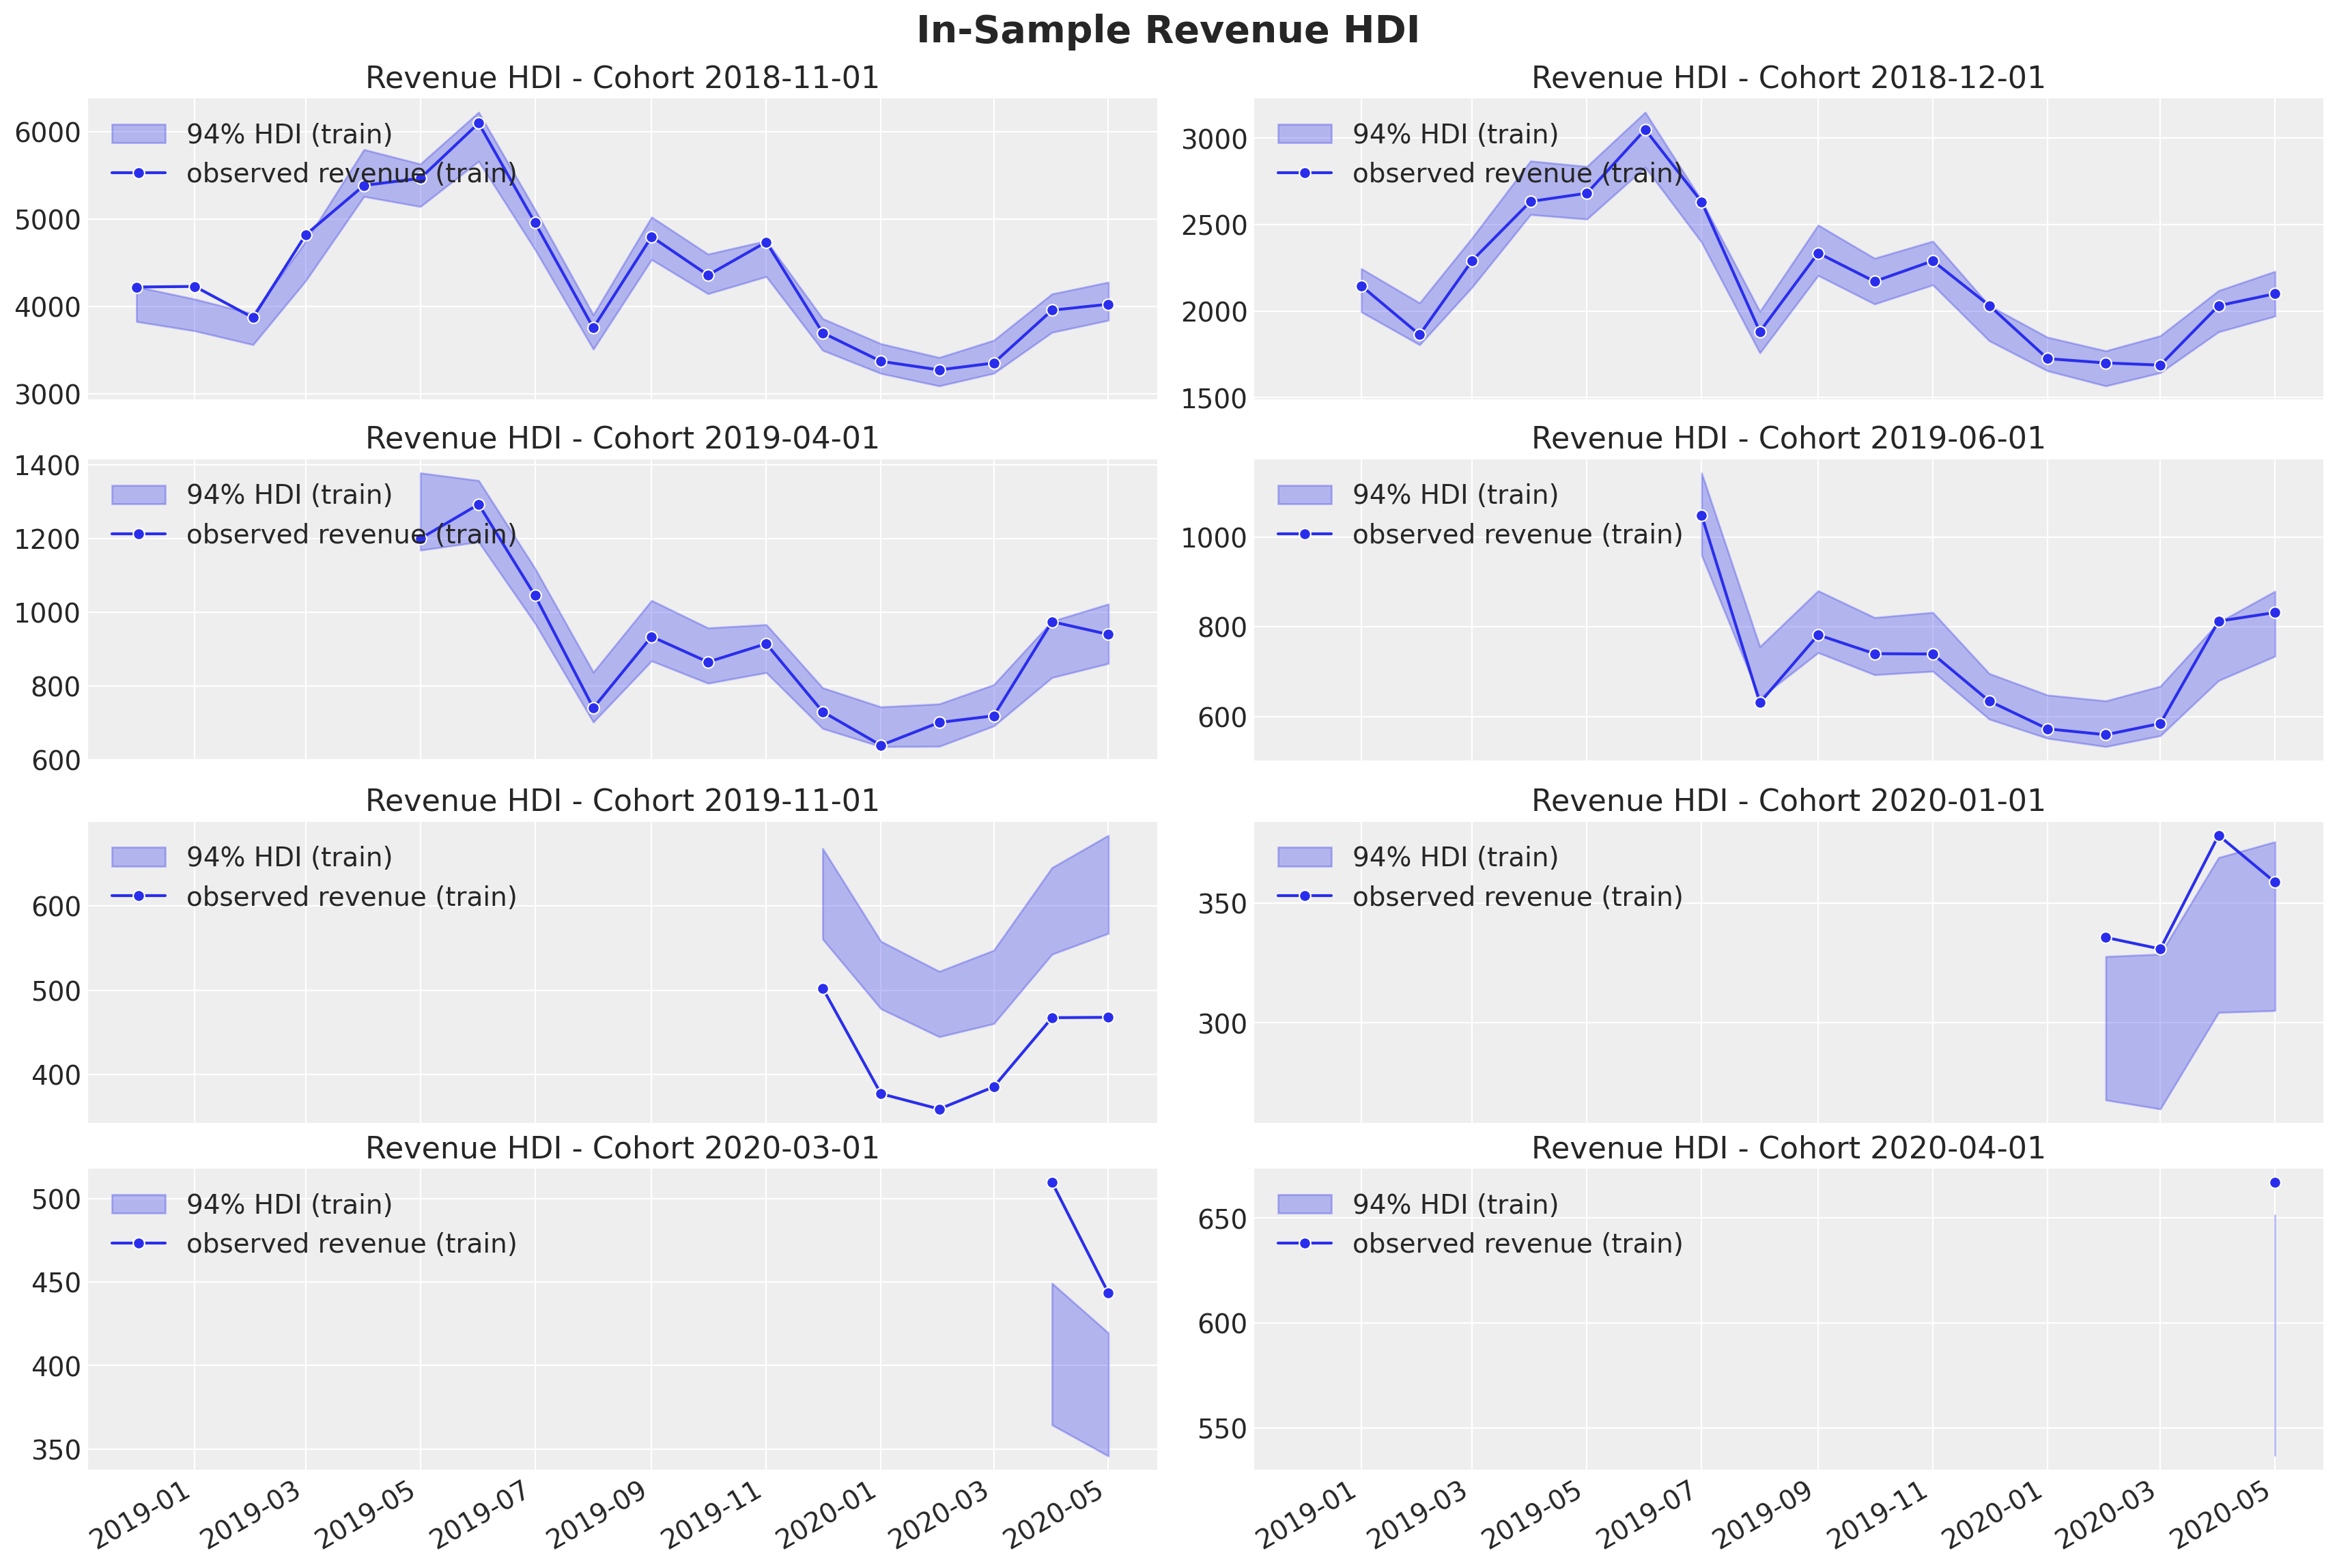

In [ ]:
fig, axes = plt.subplots(
    nrows=np.ceil(len(cohort_index_to_plot) / 2).astype(int),
    ncols=2,
    figsize=(17, 11),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)

fig.suptitle("In-Sample Revenue HDI", y=1.03, fontsize=20, fontweight="bold")
fig.autofmt_xdate()

## Revenue per User Analysis

We analyze the posterior means for revenue per user and revenue per active user
to understand how these metrics vary with cohort age.

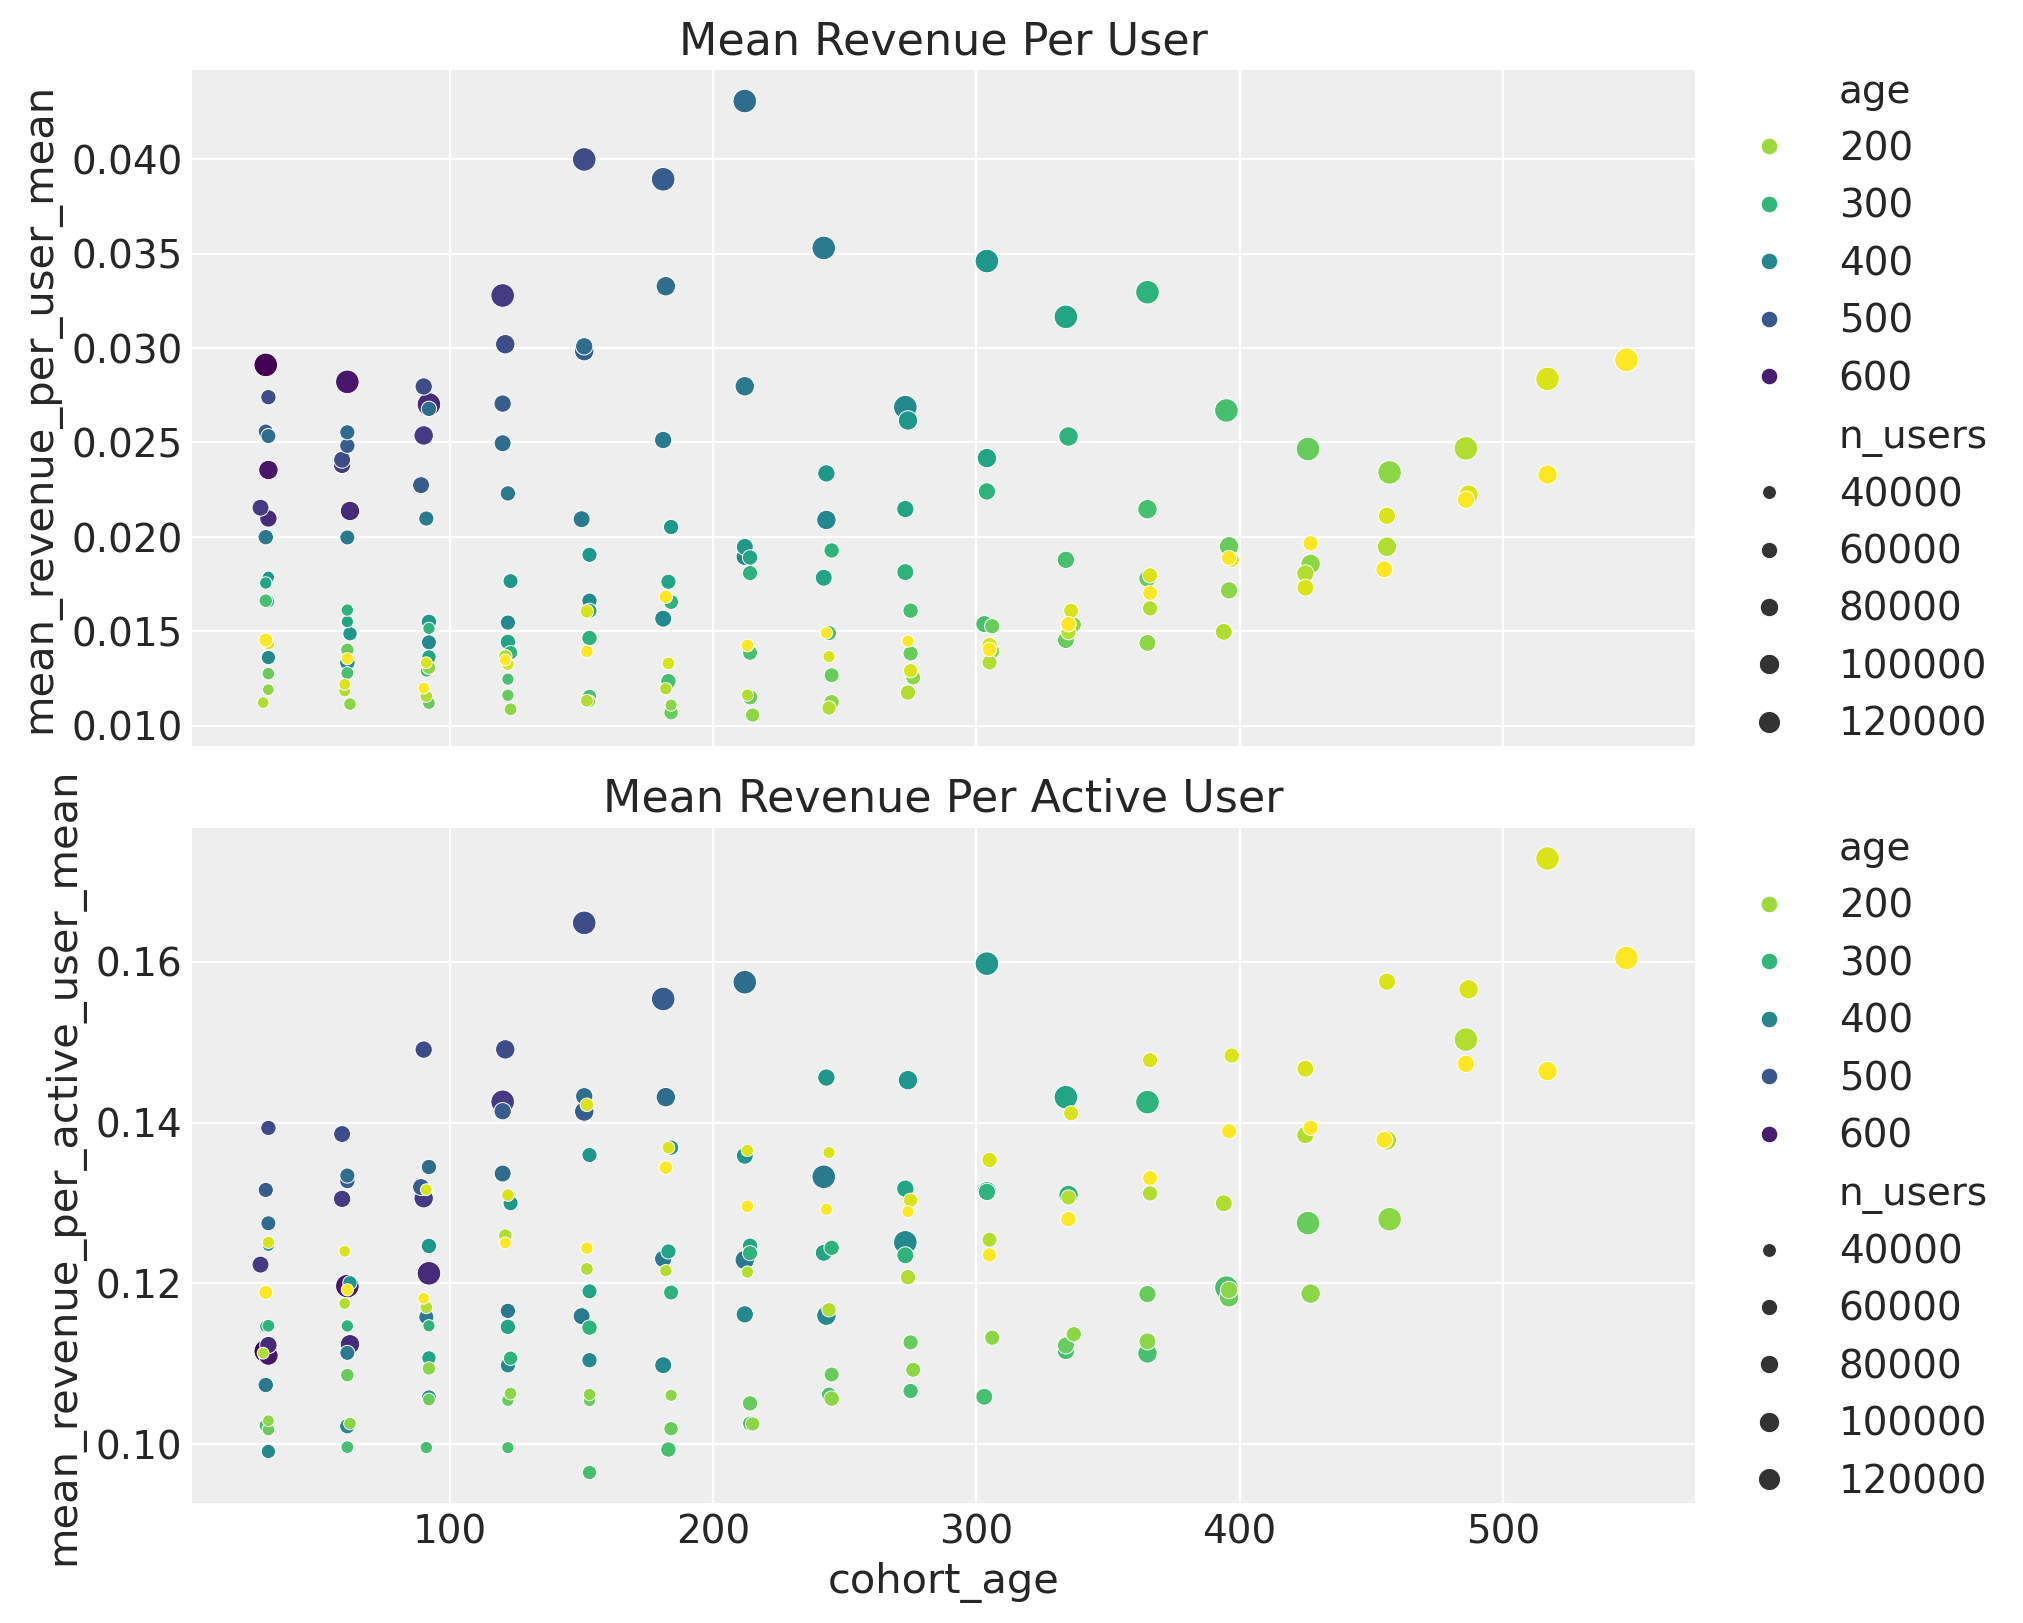

In [ ]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 8),
    sharex=True,
    sharey=False,
    layout="constrained",
)

(
    train_data_red_df.to_pandas()
    .assign(
        mean_revenue_per_user_mean=idata["posterior"]["mean_revenue_per_user"].mean(
            dim=["chain", "draw"]
        ),
    )
    .pipe(
        (sns.scatterplot, "data"),
        x="cohort_age",
        y="mean_revenue_per_user_mean",
        hue="age",
        palette="viridis_r",
        size="n_users",
        ax=ax[0],
    )
)
ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[0].set(title="Mean Revenue Per User")

(
    train_data_red_df.to_pandas()
    .assign(
        mean_revenue_per_active_user_mean=idata["posterior"][
            "mean_revenue_per_active_user"
        ].mean(dim=["chain", "draw"]),
    )
    .pipe(
        (sns.scatterplot, "data"),
        x="cohort_age",
        y="mean_revenue_per_active_user_mean",
        hue="age",
        palette="viridis_r",
        size="n_users",
        ax=ax[1],
    )
)
ax[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set(title="Mean Revenue Per Active User");

## Out-of-Sample Predictions

We now make predictions on the test set to evaluate the model's generalization performance.

### Test Data Transformations

We transform the test data using the same scalers and encoders fitted on the training data.

In [ ]:
test_data_red_df = test_data_df.filter(pl.col("cohort_age").gt(pl.lit(0)))
test_data_red_df = test_data_red_df.filter(
    pl.col("cohort").is_in(train_data_red_df["cohort"].unique().to_list())
)

test_data_red_df = test_data_red_df.with_columns(
    [
        pl.col("cohort").dt.month().alias("cohort_month"),
        pl.col("period").dt.month().alias("period_month"),
    ]
)

test_obs_idx = range(
    train_data_red_df.height, train_data_red_df.height + test_data_red_df.height
)
test_n_users = test_data_red_df["n_users"].to_numpy()
test_n_active_users = test_data_red_df["n_active_users"].to_numpy()
test_retention = test_data_red_df["retention"].to_numpy()
test_revenue = test_data_red_df["revenue"].to_numpy()

test_period = test_data_red_df["period"].to_numpy()

test_cohort = test_data_red_df["cohort"].to_numpy()
test_cohort_idx = train_cohort_encoder.transform(test_cohort).flatten()

test_cohort_month = test_data_red_df["cohort_month"].to_numpy()
test_cohort_month_idx = train_cohort_month_encoder.transform(
    test_cohort_month
).flatten()

test_period_month = test_data_red_df["period_month"].to_numpy()
test_period_month_idx = train_period_month_encoder.transform(
    test_period_month
).flatten()

x_test = test_data_red_df[features].to_numpy()

test_age = test_data_red_df["age"].to_numpy()
test_age_scaled = train_age_scaler.transform(test_age.reshape(-1, 1)).flatten()
test_cohort_age = test_data_red_df["cohort_age"].to_numpy()
test_cohort_age_scaled = train_cohort_age_scaler.transform(
    test_cohort_age.reshape(-1, 1)
).flatten()

In [ ]:
print(f"Test observations: {len(test_obs_idx)}")

Test observations: 72


### Out-of-Sample Posterior Predictions

We calculate the posterior predictive distribution for the test data.

In [ ]:
with model:
    pm.set_data(
        new_data={
            "age_scaled_data": test_age_scaled,
            "cohort_age_scaled_data": test_cohort_age_scaled,
            "x_data": x_test,
            "cohort_month_idx_data": test_cohort_month_idx,
            "period_month_idx_data": test_period_month_idx,
            "n_users_data": test_n_users,
            "n_active_users_data": np.ones_like(
                test_n_active_users
            ),  # Dummy data for coords
            "revenue_data": np.ones_like(test_revenue),  # Dummy data for coords
        },
        coords={"obs": test_obs_idx},
    )
    idata_oos = pm.sample_posterior_predictive(
        trace=idata,
        var_names=[
            "p",
            "mu",
            "n_active_users_estimated",
            "revenue_estimated",
            "mean_revenue_per_user",
            "mean_revenue_per_active_user",
        ],
        idata_kwargs={"coords": {"obs": test_obs_idx}},
        random_seed=rng,
    )

Sampling: [mu, n_active_users_estimated, revenue_estimated]


Output()

### Retention and Revenue Out-of-Sample Predictions

We plot the posterior predictive distribution for the retention and revenue components
comparing training and test data.

In [ ]:
test_posterior_retention = (
    idata_oos["posterior_predictive"]["n_active_users_estimated"]
    / test_n_users[np.newaxis, None]
)

test_retention_hdi = az.hdi(ary=test_posterior_retention)["n_active_users_estimated"]
test_revenue_hdi = az.hdi(ary=idata_oos["posterior_predictive"])["revenue_estimated"]

In [ ]:
def plot_test_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.filter(
        pl.col("cohort").eq(train_cohort_encoder.classes_[cohort_index])
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_retention_hdi[mask, :][:, 0],
        y2=test_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C1",
        label="94% HDI (test)",
    )
    sns.lineplot(
        x=test_period_range,
        y=test_retention[mask],
        color="C1",
        marker="o",
        label="observed retention (test)",
        ax=ax,
    )
    return ax

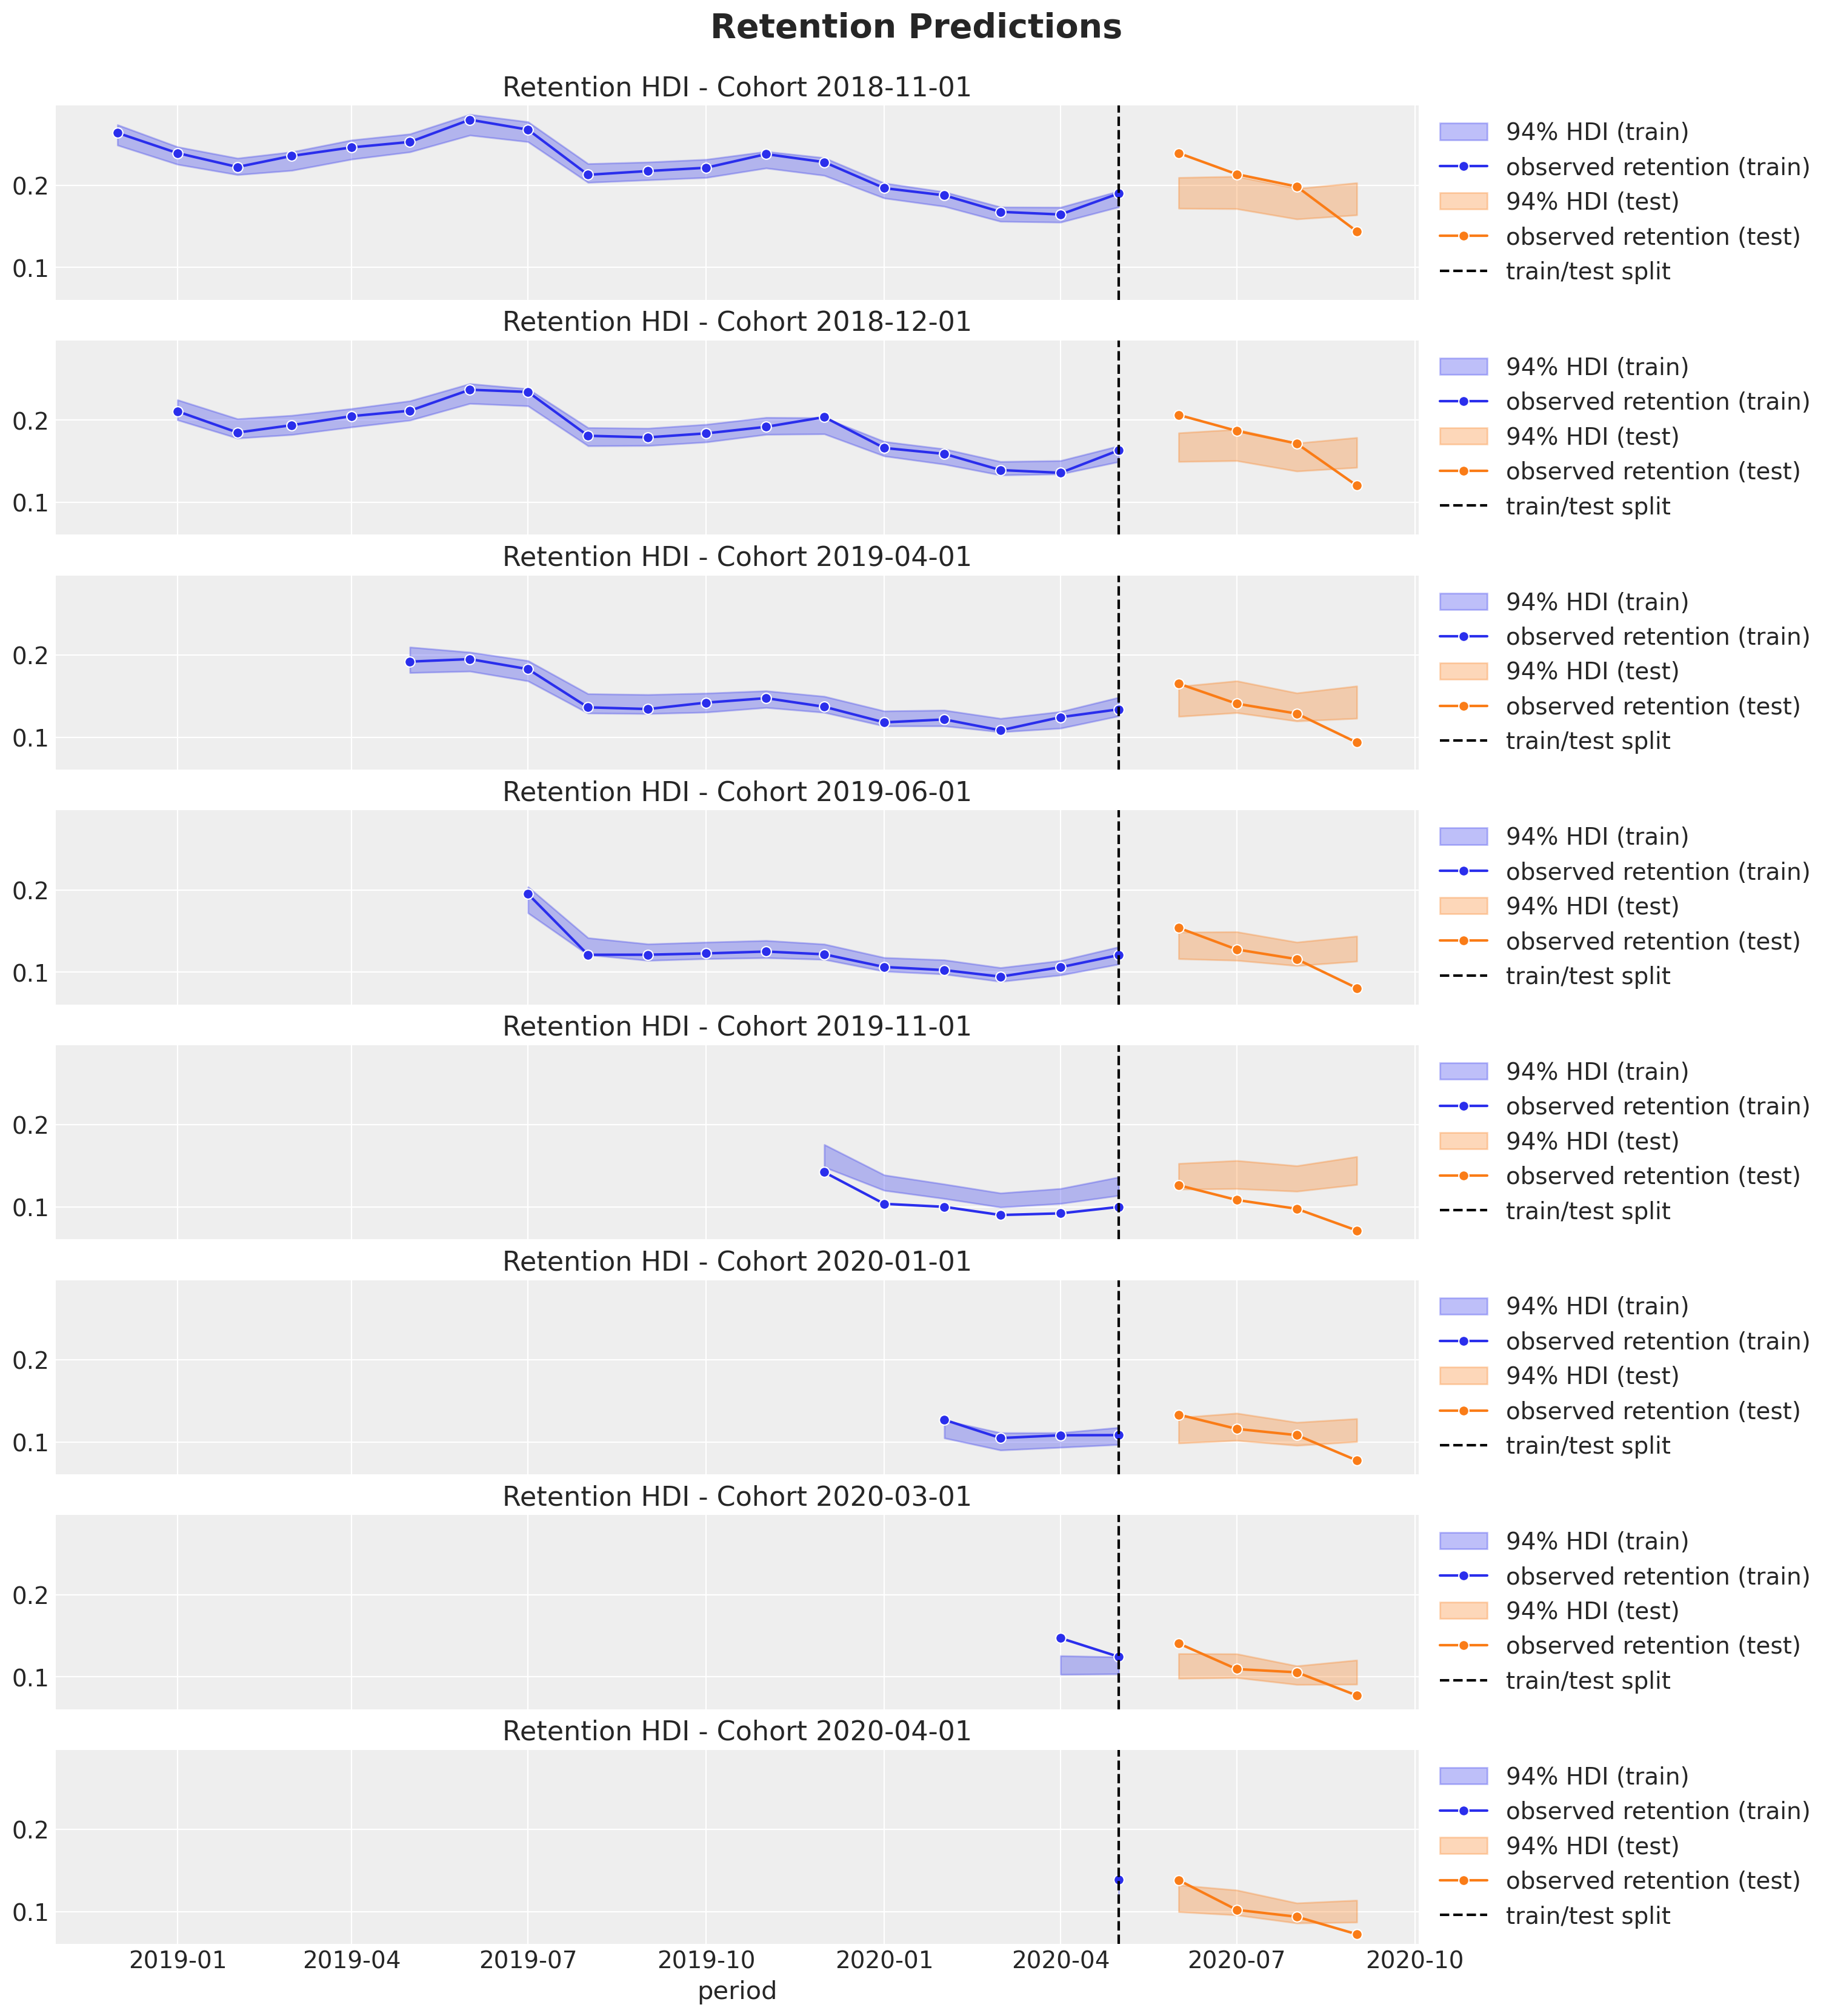

In [ ]:
fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(15, 16),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.suptitle("Retention Predictions", y=1.03, fontsize=20, fontweight="bold");

In [ ]:
def plot_test_revenue_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.filter(
        pl.col("cohort").eq(train_cohort_encoder.classes_[cohort_index])
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_revenue_hdi[mask, :][:, 0],
        y2=test_revenue_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C1",
        label="94% HDI (test)",
    )
    sns.lineplot(
        x=test_period_range,
        y=test_revenue[mask],
        color="C1",
        marker="o",
        label="observed revenue (test)",
        ax=ax,
    )
    return ax

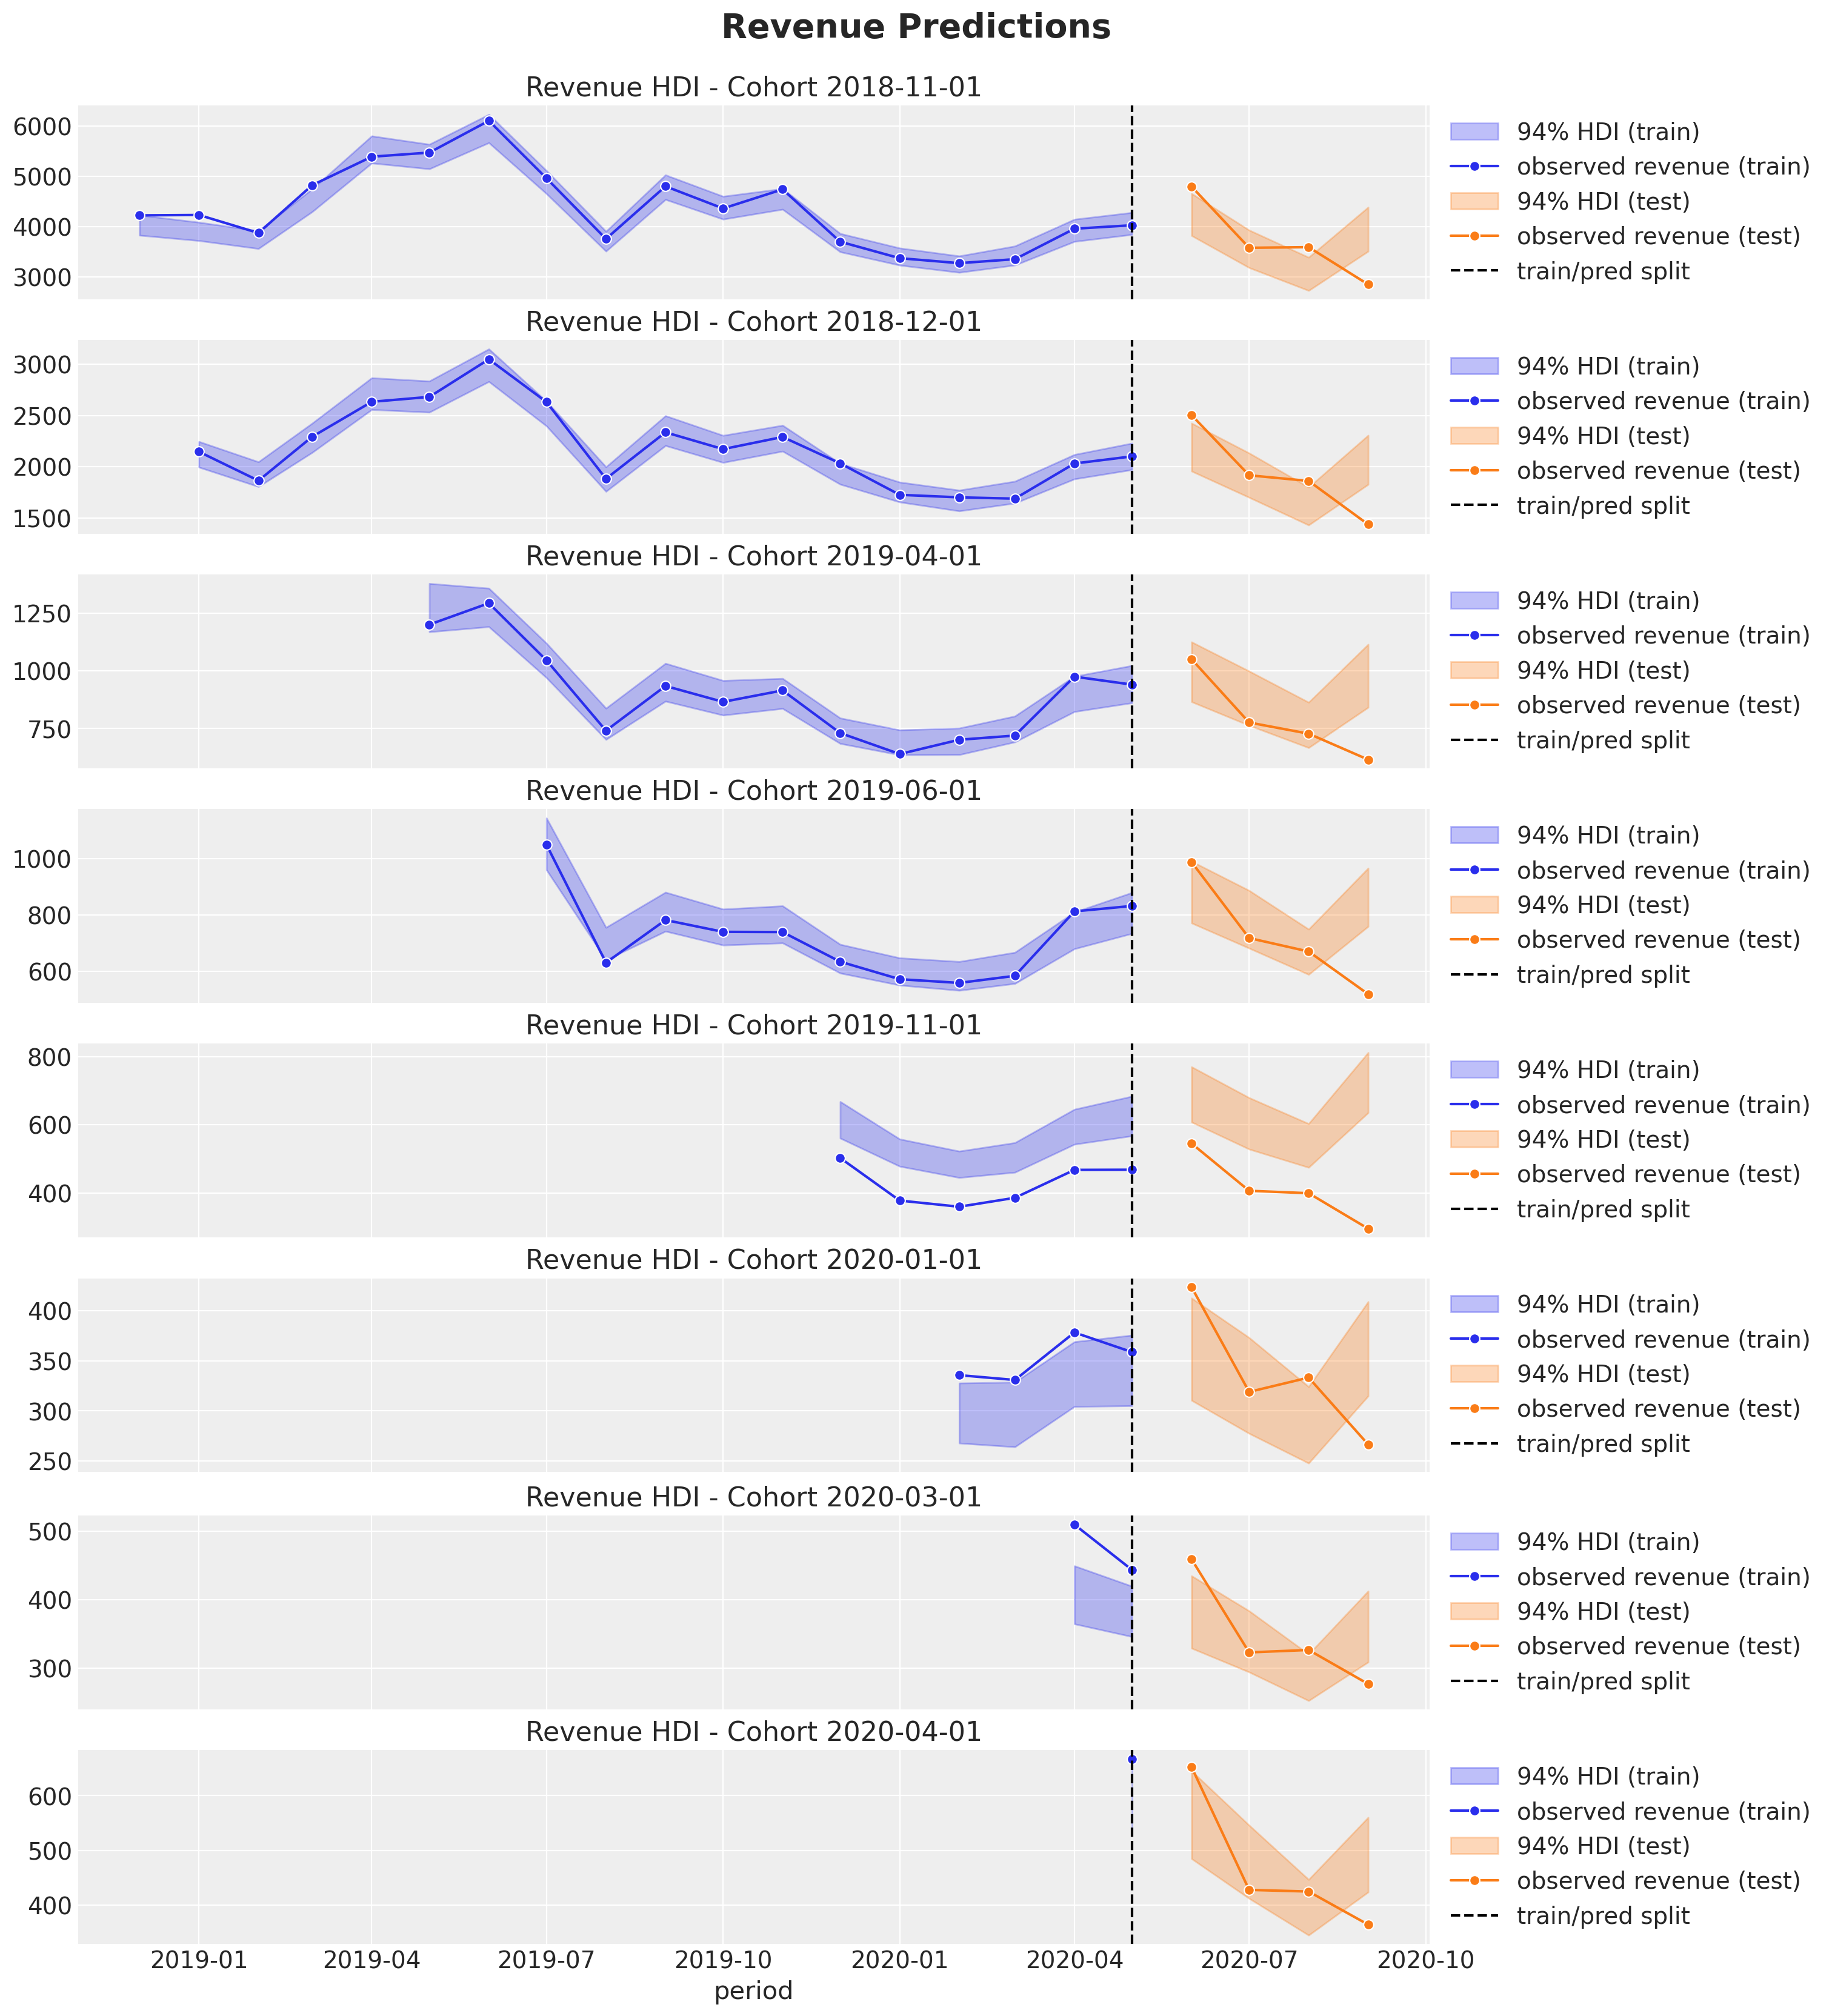

In [ ]:
fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(15, 16),
    sharex=True,
    sharey=False,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten(), strict=True):
    plot_train_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_revenue_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/pred split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.suptitle("Revenue Predictions", y=1.03, fontsize=20, fontweight="bold");

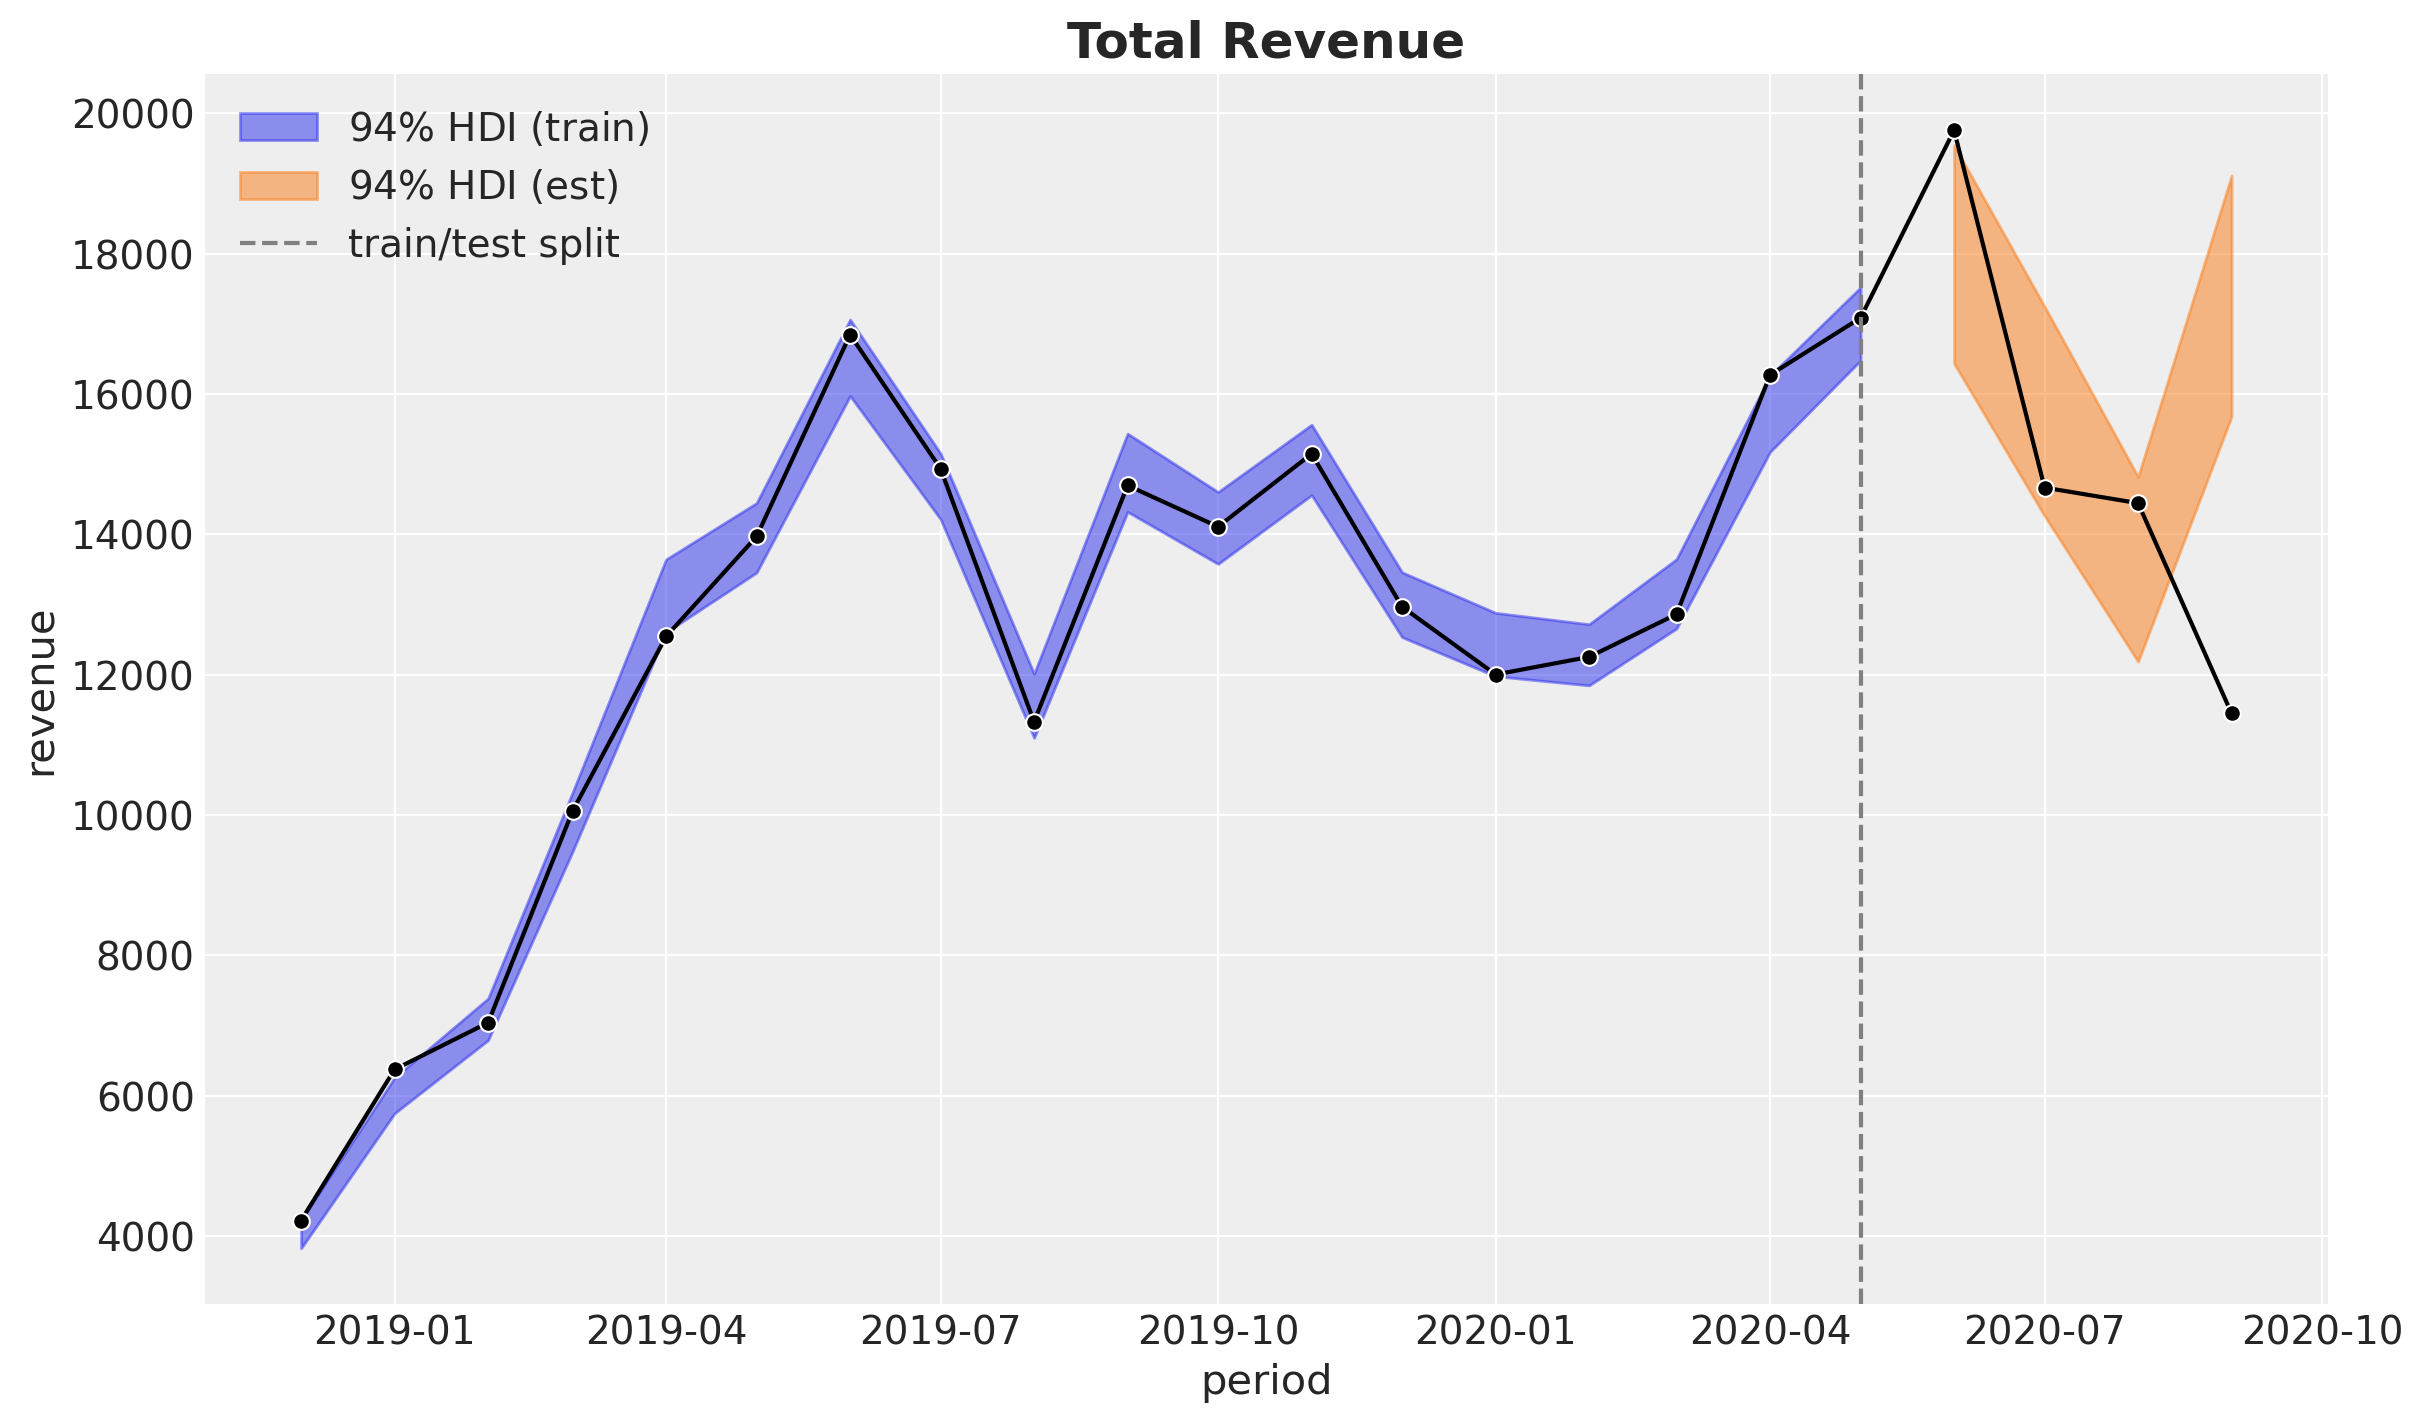

In [ ]:
train_total_revenue_predicted = (
    idata["posterior_predictive"]["revenue_estimated"]
    .rename({"obs": "period_month"})
    .assign_coords(period_month=train_period)
    .groupby("period_month")
    .sum()
)

test_total_revenue_predicted = (
    idata_oos["posterior_predictive"]["revenue_estimated"]
    .rename({"obs": "period_month"})
    .assign_coords(period_month=test_period)
    .groupby("period_month")
    .sum()
)


fig, ax = plt.subplots()

az.plot_hdi(
    x=train_total_revenue_predicted.coords["period_month"],
    y=train_total_revenue_predicted,
    hdi_prob=0.94,
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.5, "label": "$94\\%$ HDI (train)"},
    ax=ax,
)

az.plot_hdi(
    x=test_total_revenue_predicted.coords["period_month"],
    y=test_total_revenue_predicted,
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.5, "label": "$94\\%$ HDI (est)"},
    ax=ax,
)

(
    cohort_df.filter(pl.col("cohort_age").gt(pl.lit(0)))
    .filter(pl.col("cohort").is_in(set(train_data_red_df["cohort"])))
    .group_by("period")
    .agg(pl.col("revenue").sum())
    .pipe(
        sns.lineplot,
        x="period",
        y="revenue",
        color="black",
        marker="o",
        ax=ax,
    )
)

ax.axvline(
    x=period_train_test_split,
    color="gray",
    linestyle="--",
    label="train/test split",
)

ax.legend(loc="upper left")

ax.set_title("Total Revenue", fontsize=18, fontweight="bold");